In [175]:
import pandas as pd
import numpy as np
import os
import re
import ast
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
#imports Seaborn library and assigns shorthand 'sns'
import seaborn as sns
#imports Plotly library and assigns shorthand 'px'
import plotly.express as px
#from typing import Literal
import more_itertools
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
from scipy.spatial import distance

In [332]:
qwen_df = pd.read_csv('../output_data/qwen.csv').drop(columns={'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'})
qwen_df

,uniqueID,text,label,created_at,month,roleplay_results,roleplay_vocab_probs,roleplay_ppl,content_results,content_vocab_probs,content_ppl,zeroshot_results,zeroshot_vocab_probs,zeroshot_ppl,fewshot_results,fewshot_vocab_probs,fewshot_ppl
0,antisexm24_uk-0,The rise of Suella Braverman is one of the gen...,sexism,2022-10-25,October,"['assistant\nneither', 'assistant\nneither', '...","[array([4.6691503e-07, 1.4206543e-06, 5.583822...","[1.2128075, 1.2128075, 1.2128075]","['assistant\nanti-sexist', 'assistant\nanti-se...","[array([5.0719513e-07, 2.7837077e-06, 1.456983...","[1.0498952, 1.0498952, 1.0498952]","['assistant\nneither', 'assistant\nneither', '...","[array([6.9694806e-07, 4.6108407e-06, 2.433619...","[1.7570196, 1.7570196, 1.7570196]","['assistant\nanti-sexist', 'assistant\nanti-se...","[array([3.0329446e-07, 3.0196907e-06, 5.256067...","[1.1162703, 1.1162703, 1.7834034]"
1,antisexm24_uk-1,"General Election please! 81,000 Tory members v...",neither,2022-09-06,September,"['assistant\nneither', 'assistant\nneither', '...","[array([2.5813670e-06, 7.6909754e-07, 1.358537...","[1.1981286, 1.1981286, 1.1981286]","['assistant\nanti-sexist', 'assistant\nanti-se...","[array([9.2248888e-07, 1.1047561e-06, 3.517432...","[1.0217568, 1.0217568, 1.0217568]","['assistant\nneither', 'assistant\nneither', '...","[array([2.1754834e-06, 3.7426375e-06, 3.031083...","[1.2812291, 1.2812291, 1.2812291]","['assistant\nneither', 'assistant\nneither', '...","[array([1.98379030e-06, 2.47372986e-06, 1.0400...","[1.5179037, 1.5179037, 1.5179037]"
2,antisexm24_uk-10,If you think you are having a tough day spare ...,neither,2022-09-06,September,"['assistant\nanti-sexist', 'assistant\nanti-se...","[array([1.4193588e-06, 2.4912529e-06, 5.267531...","[1.0546654, 1.0546654, 1.0546654]","['assistant\nantiseistic', 'assistant\nanti-se...","[array([1.2838709e-06, 5.6511917e-06, 3.483629...","[3.7672522, 1.0618707, 1.0618707]","['assistant\n anti-sexist', 'assistant\...","[array([9.2552420e-07, 3.8282114e-06, 1.839329...","[1.4492946, 1.4492946, 3.662945]","['assistant\nneither', 'assistant\nneither', '...","[array([1.2480763e-06, 3.4312002e-06, 1.513242...","[2.122291, 2.122291, 2.122291]"
3,antisexm24_uk-100,"Already it seems Liz Truss"" ""energy price free...",neither,2022-09-05,September,"['assistant\nneither', 'assistant\nneither', '...","[array([2.8393622e-06, 2.1766680e-06, 5.945831...","[1.3400106, 1.3400106, 1.3400106]","['assistant\nanti-sexist', 'assistant\nanti-se...","[array([3.0539595e-06, 4.4958583e-06, 1.932512...","[1.0407891, 1.0407891, 1.0407891]","['assistant\nneither', 'assistant\nneither', '...","[array([2.2436316e-06, 8.0245218e-06, 5.513841...","[1.6607466, 1.6607466, 1.6607466]","['assistant\nneither', 'assistant\nneither', '...","[array([1.5110818e-06, 3.7256664e-06, 6.255290...","[1.3454994, 1.3454994, 1.3454994]"
4,antisexm24_uk-101,@pritipatel This is not about the location of ...,neither,2022-02-26,February,"['assistant\nneither', 'assistant\nneither', '...","[array([1.3062735e-06, 2.7388101e-06, 2.108910...","[1.2522104, 1.2522104, 1.2522104]","['assistant\nanti-sexist', 'assistant\nanti-se...","[array([1.8232034e-06, 6.4977853e-06, 6.399506...","[1.0862261, 1.0862261, 1.0862261]","['assistant\nneither', 'assistant\nneither', '...","[array([2.03946070e-06, 1.17598720e-05, 1.3723...","[2.3372564, 2.3372564, 1.2204887]","['assistant\nanti-sexist', 'assistant\nanti-se...","[array([5.7344948e-07, 2.9498551e-06, 7.671774...","[1.0858179, 1.0858179, 1.0858179]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,antisexm24_uk_pilot-784,Boris Johnson visited Gigg Lane stadium today....,neither,25/04/2022,April,"['assistant\nneither', 'assistant\nneither', '...","[array([3.9751076e-06, 1.6738250e-06, 2.512972...","[1.5833993, 1.5833993, 1.5833993]","['assistant\nanti-sexist', 'assistant\nanti-se...","[array([2.8701691e-06, 3.9312026e-06, 1.320111...","[1.0420536, 1.0420536, 1.0420536]","['assistant\nneither', 'as

In [333]:
def qwen_postprocessing(text):
    #text = re.sub(r"\s+", " ", text)
    #text = text.encode(encoding='ASCII',errors='ignore').decode()
    text = re.sub(r"\s+", " ", text).lower().replace("assistant\\n", "")
    text = text.encode(encoding='ASCII',errors='ignore').decode()

    text = text.replace('2) anti-sexist', 'anti-sexist')
    text = text.replace('3) neither', 'neither')
    text = text.replace('3', 'neither')
    text = text.replace('1) sexist', 'sexist')
    text = text.replace('1) anti-sexist', 'anti-sexist')

    try:
        if text == 'neither':
            values = ['neither', 'neither', 'neither']

        else:
            ## first changing the string literals

            text = text.replace('neutral or neither', 'neither')
            text = text.replace('neutral', 'neither')
            text = ast.literal_eval(text)

            values = []
            for key, val in enumerate(text):
                val = re.sub(r'\n+', '\n', val).split('\n')[0].strip()
                val = val.split('.')[0].strip()
                #val = val.replace('\\n', ';').split(';')[0]
                val = val.split('(')[0].strip()
                if ('cannot provide a label' in val) or ('cannot create' in val):
                    values.append('neither')
                elif (('does not contain' in val) or ('not' in val)) and ('sexist or anti-') in val:
                    values.append('neither')
                elif ('neither' in val) and ('nor' in val):
                    values.append('neither')
                elif (('is' in val) or ('perceived as' in val)) and ('anti-' in val):
                    values.append('anti-sexist')
                elif (('is' in val) or ('perceived as' in val)) and (('sexist' in val) or ('sex' in val)): # 
                    values.append('sexist')
                elif ('the label is: 1' in val) or ('misogyn' in val):
                    values.append('sexist')
                elif val not in ['neither', 'anti-sexist', 'sexist']:
                    a = get_mnli_prediction('anti-sexist', val)
                    b = get_mnli_prediction('sexist', val)
                    c = get_mnli_prediction('neither', val)
                    max = maximum(a, b, c)
                    if max == a:
                        values.append('anti-sexist')
                    elif max == b:
                        values.append('sexist')
                    else:
                        values.append('neither')
                else:
                    values.append(val)
    except Exception as e:
        values = np.nan
    
    return values



In [338]:
qwen_postprocessing("['assistant\\n3 - anti-sexist', 'assistant\\n3 - anti-sexist', 'assistant\\n3 - anti-sexist']")

['anti-sexist', 'anti-sexist', 'anti-sexist']

In [335]:
qwen_df['roleplay_results'] = qwen_df['roleplay_results'].apply(lambda x: qwen_postprocessing(x))
qwen_df['content_results'] = qwen_df['content_results'].apply(lambda x: qwen_postprocessing(x))
qwen_df['zeroshot_results'] = qwen_df['zeroshot_results'].apply(lambda x: qwen_postprocessing(x))
qwen_df['fewshot_results'] = qwen_df['fewshot_results'].apply(lambda x: qwen_postprocessing(x))

In [341]:
qwen_df['roleplay_ppl'] = qwen_df['roleplay_ppl'].apply(lambda x: handling_error_ppls(x))
qwen_df['content_ppl'] = qwen_df['content_ppl'].apply(lambda x: handling_error_ppls(x))
qwen_df['zeroshot_ppl'] = qwen_df['zeroshot_ppl'].apply(lambda x: handling_error_ppls(x))
qwen_df['fewshot_ppl'] = qwen_df['fewshot_ppl'].apply(lambda x: handling_error_ppls(x))

In [168]:
def same_output_check(lst):
    if([lst[0]]*len(lst) == lst):
        res = True
    else:
        res = False
    return res

In [170]:
qwen_df['avg_r_ppl'] = qwen_df['roleplay_ppl'].apply(lambda x: np.average(x))
qwen_df['avg_c_ppl'] = qwen_df['content_ppl'].apply(lambda x: np.average(x))
qwen_df['avg_z_ppl'] = qwen_df['zeroshot_ppl'].apply(lambda x: np.average(x))
qwen_df['avg_f_ppl'] = qwen_df['fewshot_ppl'].apply(lambda x: np.average(x))

In [171]:
type(qwen_df['roleplay_results'].iloc[0])

list

In [172]:
qwen_df['avg_r_ppl'].iloc[0]

1.2128075

In [173]:
qwen_df['roleplay_ppl'].iloc[0]


[1.2128075, 1.2128075, 1.2128075]

In [174]:
same_output_check(qwen_df['roleplay_vocab_probs'].iloc[0])

False

In [175]:
qwen_df['r_sum_res'] = qwen_df['roleplay_results'].apply(lambda x: same_output_check(x))
qwen_df['c_sum_res'] = qwen_df['content_results'].apply(lambda x: same_output_check(x))
qwen_df['z_sum_res'] = qwen_df['zeroshot_results'].apply(lambda x: same_output_check(x))
qwen_df['f_sum_res'] = qwen_df['fewshot_results'].apply(lambda x: same_output_check(x))

In [342]:
qwen_df = qwen_df.dropna(subset=['roleplay_results', 'content_results', 'zeroshot_results', 'fewshot_results'])

In [177]:
qwen_df['content_vocab_probs'].iloc[0]

'[array([5.0719513e-07, 2.7837077e-06, 1.4569837e-06, ..., 8.5292502e-11,\n       8.5598542e-11, 8.5292502e-11], dtype=float32), array([5.0719513e-07, 2.7837077e-06, 1.4569837e-06, ..., 8.5292502e-11,\n       8.5598542e-11, 8.5292502e-11], dtype=float32), array([5.0719513e-07, 2.7837077e-06, 1.4569837e-06, ..., 8.5292502e-11,\n       8.5598542e-11, 8.5292502e-11], dtype=float32)]'

In [3]:
mnli_model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-large-mnli")
mnli_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-large-mnli")
mnli_model.to(device='cuda')

2024-12-04 18:36:27.151262: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 18:36:27.162889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 18:36:27.175989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 18:36:27.179857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 18:36:27.189673: I tensorflow/core/platform/cpu_feature_guar

DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=1024, out_features=3072, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=1024, out_features=1024, bias=False)
              (pos_q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
   

In [4]:
def get_mnli_prediction(answer1, answer2):
    input_str = answer1 + ' [SEP] ' + answer2
    encoded_input = mnli_tokenizer(input_str, return_tensors="pt").to(device='cuda')
    prediction = mnli_model(input_ids=encoded_input["input_ids"],
                                     token_type_ids=encoded_input["token_type_ids"]).logits
    predicted_label = torch.argmax(prediction, dim=1).item()

    return predicted_label

In [5]:
get_mnli_prediction('sexist', 'not sexist')

0

In [178]:
def evaluate_semantic_sim(generated_samples):
    entail_info = {idx:[] for idx in range(len(generated_samples))}

    for i, answer_1 in enumerate(generated_samples):
        for j in range(i+1, len(generated_samples)):
            pred = get_mnli_prediction(generated_samples[i], generated_samples[j])
            reverse_pred = get_mnli_prediction(generated_samples[j], generated_samples[i])

            # entailment is 2
            if pred == 2 and reverse_pred == 2:
                entail_info[i].append(j)
                entail_info[j].append(i)

    cluster_list = []
    for idx, idx_entails in entail_info.items():
        cluster = [idx]
        for ent in idx_entails:
            if idx in entail_info[ent]:
                flag = False
                for other_member in cluster:
                    if other_member in entail_info[ent] and ent in entail_info[other_member]:
                        flag = True
                    else:
                        flag = False
                if flag:
                    cluster.append(ent)
        cluster_str = [str(mem) for mem in sorted(cluster)]
        cluster_list.append("-".join(cluster_str))

    return list(set(cluster_list))

In [179]:
def get_mnli_prediction(self, answer1, answer2):
    input_str = answer1 + ' [SEP] ' + answer2
    encoded_input = mnli_tokenizer(input_str, return_tensors="pt").to(device)
    prediction = mnli_model(input_ids=encoded_input["input_ids"],
                                     token_type_ids=encoded_input["token_type_ids"]).logits
    predicted_label = torch.argmax(prediction, dim=1).item()

    return predicted_label

In [345]:
qwen_df['label'] = qwen_df['label'].apply(lambda x: label_modifiy(x))

In [181]:
data_labels = qwen_df[['month', 'label']]
data_labels = data_labels.groupby('month')['label'].value_counts().reset_index()
data_labels['percentage'] = round(100 * data_labels['count'] / data_labels.groupby('month')['count'].transform('sum'), 2)
#data_labels['created_at'] = data_labels['created_at'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))
data_labels = data_labels.sort_values(by='month')
data_labels

,month,label,count,percentage
0,April,neither,351,76.64
1,April,anti-sexism,60,13.10
2,April,sexism,47,10.26
3,February,neither,61,77.22
4,February,sexism,10,12.66
5,February,anti-sexism,8,10.13
7,March,sexism,4,16.67
8,March,anti-sexism,1,4.17
6,March,neither,19,79.17
9,May,neither,24,88.89


In [182]:
data_labels_dates = list(data_labels['month'].unique())

data_labels_label_neither = data_labels[data_labels['label'] == 'neither']['percentage'].to_list()
data_labels_label_sexism = data_labels[data_labels['label'] == 'sexism']['percentage'].to_list()
data_labels_label_antisexism = data_labels[data_labels['label'] == 'anti-sexism']['percentage'].to_list()

data_labels_bylabel = data_labels.sort_values(by='label')
data_labels_bylabel["label"] = pd.Categorical(data_labels_bylabel["label"], categories = ['neither', 'anti-sexism', 'sexism'])
data_labels_bylabel = data_labels_bylabel.sort_values(by = 'label')

percent_list = data_labels_bylabel['percentage'].to_list()

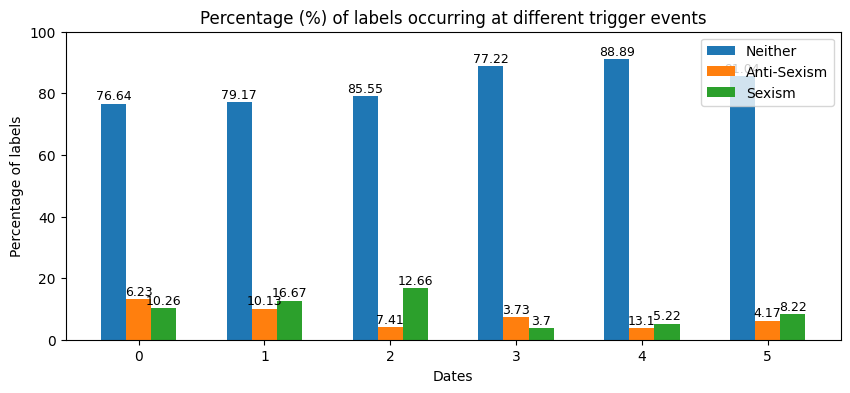

In [183]:
X_axis = np.arange(len(data_labels_dates)) 

fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(X_axis - 0.2, data_labels_label_neither, 0.2, label = 'Neither') 
ax.bar(X_axis, data_labels_label_antisexism, 0.2, label = 'Anti-Sexism') 
ax.bar(X_axis + 0.2, data_labels_label_sexism, 0.2, label = 'Sexism') 

#plt.xticks(X_axis, ['2022-04-25 \nSexist event', '2022-09-06 \nPolitical event', '2022-10-25 \nNormal time']) 
ax.set_xlabel("Dates") 
ax.set_ylabel("Percentage of labels") 
ax.set_title("Percentage (%) of labels occurring at different trigger events") 

rects = ax.patches

# Make some labels.
labels = [f"{i}" for i in percent_list]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0.3, label, ha="center", va="bottom", fontsize=9
    )
plt.ylim([0, 100])
plt.legend() 
plt.show() 

In [184]:
qwen_df['month'] = qwen_df['month'].astype("category")
qwen_df['month'] = qwen_df['month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

qwen_df['label'] = qwen_df['label'].astype("category")
qwen_df['label'] = qwen_df['label'].cat.set_categories(['sexism', 'anti-sexism', 'neither'])

qwen_df.sort_values(["month", 'label'])

,uniqueID,text,label,created_at,month,roleplay_results,roleplay_vocab_probs,roleplay_ppl,content_results,content_vocab_probs,...,fewshot_vocab_probs,fewshot_ppl,avg_r_ppl,avg_c_ppl,avg_z_ppl,avg_f_ppl,r_sum_res,c_sum_res,z_sum_res,f_sum_res
78,antisexm24_uk-169,Instagram Secretary Liz Truss is on a city min...,sexism,2022-02-10,February,"[neither, neither, neither]","[array([2.2875884e-06, 2.0133079e-06, 3.459831...","[1.2780697, 1.2780697, 1.2780697]","[anti-sexist, anti-sexist, anti-sexist]","[array([2.4863955e-06, 4.1593748e-06, 2.691245...",...,"[array([8.9551776e-07, 3.7597465e-06, 6.676806...","[1.1792297, 1.1792297, 1.1792297]",1.278070,1.034133,1.434231,1.179230,True,True,True,True
120,antisexm24_uk-206,Vladimir Putin threatening nuclear war after h...,sexism,2022-02-28,February,"[neither, neither, neither]","[array([1.0540865e-06, 1.3855791e-06, 1.496495...","[1.1398782, 1.1398782, 1.1398782]","[anti-sexist, anti-sexist, anti-sexist]","[array([1.7172775e-06, 2.7158721e-06, 2.866325...",...,"[array([1.9077775e-06, 3.8167454e-06, 8.322916...","[1.3920546, 1.3920546, 1.3920546]",1.139878,1.066505,1.622216,1.392055,True,True,True,True
129,antisexm24_uk-214,Here Is a nice photo for you Liz @trussliz - w...,sexism,2022-02-28,February,"[neither, neither, neither]","[array([1.6172957e-06, 1.3408506e-06, 1.642125...","[1.1518513, 1.1518513, 1.1518513]","[anti-sexist, neither, neither]","[array([1.1798394e-05, 6.2259337e-06, 5.893922...",...,"[array([1.6089998e-06, 3.0694141e-06, 8.957815...","[1.0789019, 1.0789019, 1.0789019]",1.151851,1.876794,1.116292,1.078902,True,False,True,True
236,antisexm24_uk-98,Priti Patel and Liz Truss are in posts at leas...,sexism,2022-02-28,February,"[neither, neither, neither]","[array([1.7157826e-06, 2.1759395e-06, 4.526014...","[1.6996609, 1.6996609, 1.6996609]","[anti-sexist, anti-sexist, anti-sexist]","[array([1.1904403e-06, 2.8190798e-06, 2.860061...",...,"[array([6.3289616e-07, 3.2249750e-06, 5.449255...","[1.1464031, 1.1464031, 1.1464031]",1.699661,1.034047,2.209108,1.146403,True,True,True,True
249,antisexm24_uk-249,"Liz Truss""s Mission to Moscow - was not about ...",sexism,2022-02-10,February,"[neither, neither, neither]","[array([5.0995783e-07, 1.1029438e-06, 3.773818...","[2.0047548, 2.0047548, 2.0047548]","[anti-sexist, anti-sexist, anti-sexist]","[array([2.1909184e-06, 3.4049283e-06, 1.072331...",...,"[array([8.2516260e-07, 1.7479622e-06, 1.622880...","[1.2122669, 1.2122669, 1.2122669]",2.004755,1.033481,1.723767,1.212267,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,antisexm24_uk_pilot-686,@LynPaul6 @SuellaBraverman Unbelievable! Sunak...,neither,25/10/2022,October,"[neither, neither, neither]","[array([8.8471313e-07, 6.8259226e-07, 2.030745...","[1.1172731, 1.1172731, 1.1172731]","[anti-sexist, anti-sexist, anti-sexist]","[array([1.6888571e-06, 2.3079983e-06, 3.714375...",...,"[array([5.2755349e-06, 2.4937299e-06, 8.248487...","[1.6572648, 1.5158349, 1.6629418]",1.117273,1.032155,1.398118,1.612014,True,True,True,False
1241,antisexm24_uk_pilot-687,@AngelaRayner Of course he has a mandate. Heâ...,neither,25/10/2022,October,"[anti-sexist, anti-sexist, anti-sexist]","[array([1.7624831e-06, 1.2075527e-06, 8.654399...","[1.0888445, 1.0888445, 1.0888445]","[anti-sexist, anti-sexist, anti-sexist]","[array([9.3857994e-07, 9.7798477e-07, 2.296611...",...,"[array([8.5137134e-07, 1.7705643e-06, 2.592192...","[1.6641545, 1.6641545, 1.6641545]",1.088844,1.027760,1.505678,1.664154,True,True,True,True
1242,antisexm24_uk_pilot-688,@Gurkester @IainDale @YvetteCooperMP @SuellaBr...,neither,25/10/2022,October,"[neither, neither, neither]","[array([2.7041831e-06, 2.6135920e-06, 2.380379...","[1.2037985, 1.2037985, 1.2037985]","[anti-sexist, anti-sexist, anti-sexist]","[array([5.2889600e-06, 6.5923878e-06, 1.687465...",...,"[array([1.54514282e-06, 3.57319982e-06, 1.6805...","[1.0986121, 1.0986121, 1.0986121]",1.203798,1.059746,1.353244,

In [347]:
month_list = qwen_df['month'].to_list()
k = 3
month_list = [list(itertools.repeat(element, k)) for element in month_list]
month_list = list(itertools.chain.from_iterable(month_list))

In [348]:
# Roleplay
data_values_r = pd.DataFrame({'Prediction': list(more_itertools.flatten(qwen_df['roleplay_results'])), 
                'Perplexity': list(more_itertools.flatten(qwen_df['roleplay_ppl'])),
                'Month': month_list})

data_values_r['Month'] = data_values_r['Month'].astype("category")
data_values_r['Month'] = data_values_r['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_r['Prediction'] = data_values_r['Prediction'].astype("category")
data_values_r['Prediction'] = data_values_r['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_r = data_values_r.sort_values(["Month", 'Prediction'])

# Content

data_values_c = pd.DataFrame({'Prediction': list(more_itertools.flatten(qwen_df['content_results'])), 
                'Perplexity': list(more_itertools.flatten(qwen_df['content_ppl'])),
                'Month': month_list})

data_values_c['Month'] = data_values_c['Month'].astype("category")
data_values_c['Month'] = data_values_c['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_c['Prediction'] = data_values_c['Prediction'].astype("category")
data_values_c['Prediction'] = data_values_c['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_c = data_values_c.sort_values(["Month", 'Prediction'])

# Zero-shot
data_values_z = pd.DataFrame({'Prediction': list(more_itertools.flatten(qwen_df['zeroshot_results'])), 
                'Perplexity': list(more_itertools.flatten(qwen_df['zeroshot_ppl'])),
                'Month': month_list})

data_values_z['Month'] = data_values_z['Month'].astype("category")
data_values_z['Month'] = data_values_z['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_z['Prediction'] = data_values_z['Prediction'].astype("category")
data_values_z['Prediction'] = data_values_z['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_z = data_values_z.sort_values(["Month", 'Prediction'])

# Few-shot

data_values_f = pd.DataFrame({'Prediction': list(more_itertools.flatten(qwen_df['fewshot_results'])), 
                'Perplexity': list(more_itertools.flatten(qwen_df['fewshot_ppl'])),
                'Month': month_list})

data_values_f['Month'] = data_values_f['Month'].astype("category")
data_values_f['Month'] = data_values_f['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_f['Prediction'] = data_values_f['Prediction'].astype("category")
data_values_f['Prediction'] = data_values_f['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_f = data_values_f.sort_values(["Month", 'Prediction'])


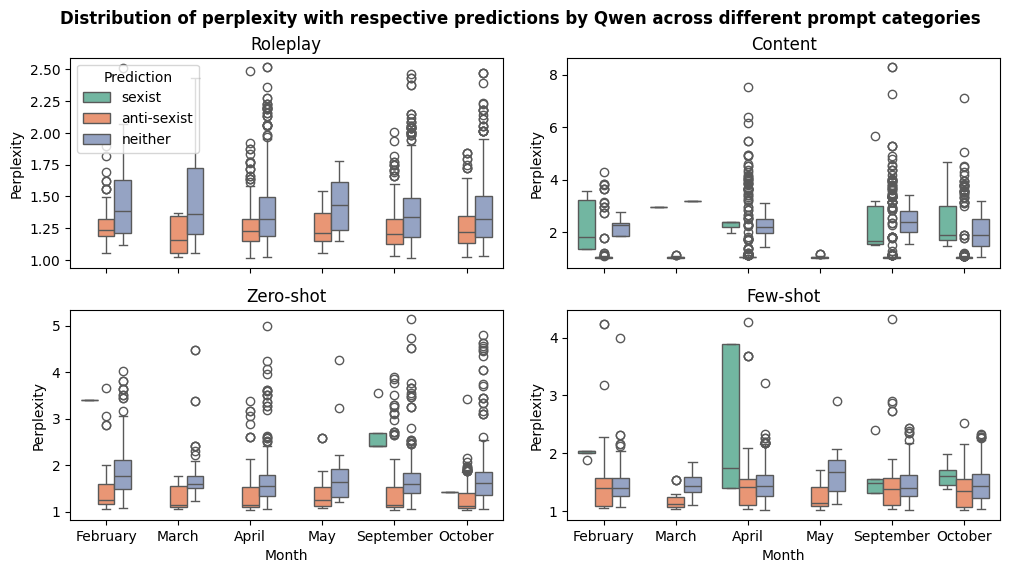

In [350]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.15, hspace=0.2)
fig.suptitle('Distribution of perplexity with respective predictions by Qwen across different prompt categories', x= 0.5, y = 0.96, weight='bold')

# Boxplot for Roleplay
#sns.boxplot(ax=axes[0, 0], data = qwen_df, x='month', y='avg_r_ppl')
sns.boxplot(ax=axs[0, 0], data = data_values_r, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7)#.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#sns.boxplot(ax=axs[0, 0], data = data_values_cor_r, x='Month', y='Roleplay Perplexity'+.10, hue='Prediction', palette='Set2', widths = 0.25, linecolor='red').get_legend().set_visible(False)
axs[0, 0].set_title('Roleplay')
#axes[0].set_title(bulbasaur.name)
#axs[0,0].set_ylim(0.5, 3)

sns.boxplot(ax=axs[0, 1], data = data_values_c, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7).get_legend().set_visible(False)
axs[0, 1].set_title('Content')

sns.boxplot(ax=axs[1, 0], data = data_values_z, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7).get_legend().set_visible(False)
axs[1, 0].set_title('Zero-shot')

sns.boxplot(ax=axs[1, 1], data = data_values_f, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7).get_legend().set_visible(False)
axs[1, 1].set_title('Few-shot')

fig.savefig("../output_images/perplexity/qwen_perplexity.pdf", bbox_inches='tight')


In [352]:
len(list(more_itertools.flatten(qwen_df['roleplay_results'].to_list()))), len(list(more_itertools.flatten(qwen_df['roleplay_ppl'].to_list())))

(4029, 4029)

In [353]:
cor_labels = qwen_df['label'].to_list()
k = 3
cor_labels = [list(itertools.repeat(element, k)) for element in cor_labels]
cor_labels = list(itertools.chain.from_iterable(cor_labels))
cor_labels

['sexist',
 'sexist',
 'sexist',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'sexist',
 'sexist',
 'sexist',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'anti-sexist',
 'anti-sexist',
 'anti-sexist',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'sexist',
 'sexist',
 'sexist',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 

In [354]:
data_values_cor_r = pd.DataFrame({'Prediction': list(more_itertools.flatten(qwen_df['roleplay_results'])), 
                'Label': cor_labels,
                'Perplexity': list(more_itertools.flatten(qwen_df['roleplay_ppl'])),
                })
data_values_cor_r['Accuracy'] = np.where(data_values_cor_r['Label'] == data_values_cor_r['Prediction'], 'Correct', 'Incorrect')
data_values_cor_r['Prompt type'] = 'Roleplay'


data_values_cor_c = pd.DataFrame({'Prediction': list(more_itertools.flatten(qwen_df['content_results'])), 
                'Label': cor_labels,
                'Perplexity': list(more_itertools.flatten(qwen_df['content_ppl'])),
                })
data_values_cor_c['Accuracy'] = np.where(data_values_cor_c['Label'] == data_values_cor_c['Prediction'], 'Correct', 'Incorrect')
data_values_cor_c['Prompt type'] = 'Content'

data_values_cor_z = pd.DataFrame({'Prediction': list(more_itertools.flatten(qwen_df['zeroshot_results'])), 
                'Label': cor_labels,
                'Perplexity': list(more_itertools.flatten(qwen_df['zeroshot_ppl'])),
                })
data_values_cor_z['Accuracy'] = np.where(data_values_cor_z['Label'] == data_values_cor_z['Prediction'], 'Correct', 'Incorrect')
data_values_cor_z['Prompt type'] = 'Zero-shot'

data_values_cor_f = pd.DataFrame({'Prediction': list(more_itertools.flatten(qwen_df['fewshot_results'])), 
                'Label': cor_labels,
                'Perplexity': list(more_itertools.flatten(qwen_df['fewshot_ppl'])),
                })
data_values_cor_f['Accuracy'] = np.where(data_values_cor_f['Label'] == data_values_cor_f['Prediction'], 'Correct', 'Incorrect')
data_values_cor_f['Prompt type'] = 'Few-shot'

data_values_cor = pd.concat([data_values_cor_r, data_values_cor_c, data_values_cor_z, data_values_cor_f], axis=0)
data_values_cor


,Prediction,Label,Perplexity,Accuracy,Prompt type
0,neither,sexist,1.212808,Incorrect,Roleplay
1,neither,sexist,1.212808,Incorrect,Roleplay
2,neither,sexist,1.212808,Incorrect,Roleplay
3,neither,neither,1.198129,Correct,Roleplay
4,neither,neither,1.198129,Correct,Roleplay
...,...,...,...,...,...
4024,anti-sexist,neither,1.094490,Incorrect,Few-shot
4025,anti-sexist,neither,1.094490,Incorrect,Few-shot
4026,neither,neither,1.709732,Correct,Few-shot
4027,neither,neither,1.709732,Correct,Few-shot


In [355]:

data_values_cor_a = data_values_cor[data_values_cor['Prediction'] == 'anti-sexist']
data_values_cor_s = data_values_cor[data_values_cor['Prediction'] == 'sexist']

Text(0.5, 1.0, 'Sexism')

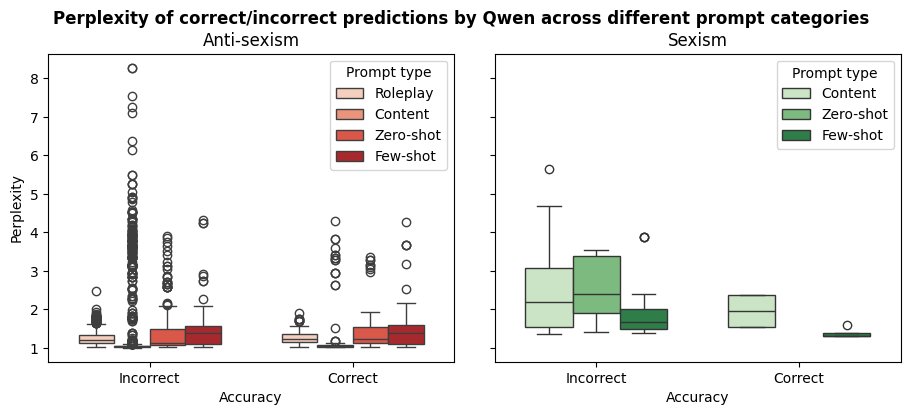

In [356]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11, 4))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('Perplexity of correct/incorrect predictions by Qwen across different prompt categories', x= 0.5, y = 0.99, weight='bold')

# Boxplot for Roleplay
#sns.boxplot(ax=axes[0, 0], data = qwen_df, x='month', y='avg_r_ppl')
sns.boxplot(ax=axs[0], data = data_values_cor_a, x='Accuracy', y='Perplexity', hue='Prompt type', palette='Reds', width=0.7)#.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#sns.boxplot(ax=axs[0, 0], data = data_values_cor_r, x='Month', y='Roleplay Perplexity'+.10, hue='Prediction', palette='Set2', widths = 0.25, linecolor='red').get_legend().set_visible(False)
axs[0].set_title('Anti-sexism')
#axes[0].set_title(bulbasaur.name)
#axs[0,0].set_ylim(0.5, 3)

sns.boxplot(ax=axs[1], data = data_values_cor_s, x='Accuracy', y='Perplexity', hue='Prompt type', palette='Greens', width=0.7)#.get_legend().set_visible(False)
axs[1].set_title('Sexism')

fig.savefig("../output_images/perplexity/qwen_perplexity_cor.pdf", bbox_inches='tight')

In [342]:
data_values_c

,Prediction,Roleplay Perplexity,Month
12,anti-sexist,1.086226,February
13,anti-sexist,1.086226,February
14,anti-sexist,1.086226,February
45,anti-sexist,1.050811,February
46,anti-sexist,1.050811,February
...,...,...,...
3608,NaN,1.897949,October
3622,NaN,2.754784,October
3623,NaN,3.948661,October
3643,NaN,4.495423,October


<AxesSubplot: xlabel='Month', ylabel='Roleplay Perplexity'>

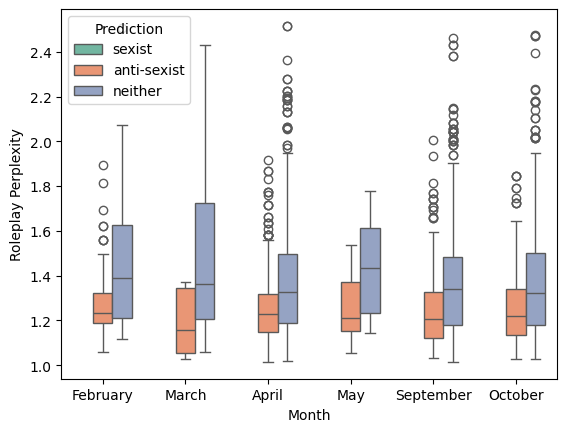

In [290]:
sns.boxplot(data = data_values, x='Month', y='Roleplay Perplexity', hue='Prediction', palette='Set2', width=0.7)

In [279]:
data_values_cor_r = pd.DataFrame({'Prediction': list(more_itertools.flatten(qwen_df['roleplay_results'].to_list())), 
                'Label': cor_labels_r,
                'Roleplay Perplexity': list(more_itertools.flatten(qwen_df['roleplay_ppl'].to_list())),
                'Month': newList})
data_values_cor_r = data_values_cor_r[data_values_cor_r['Label'] == data_values_cor_r['Prediction']]
data_values_cor_r

,Prediction,Label,Roleplay Perplexity,Month
3,neither,neither,1.198129,September
4,neither,neither,1.198129,September
5,neither,neither,1.198129,September
9,neither,neither,1.340011,September
10,neither,neither,1.340011,September
...,...,...,...,...
4020,neither,neither,1.264468,April
4021,neither,neither,1.264468,April
4022,neither,neither,1.264468,April
4023,neither,neither,2.056908,April


In [ ]:
data_values = pd.DataFrame({'Prediction': list(more_itertools.flatten(qwen_df['roleplay_results'].to_list())), 
                'Roleplay Perplexity': list(more_itertools.flatten(qwen_df['roleplay_ppl'].to_list())),
                'Month': newList})

data_values['Month'] = data_values['Month'].astype("category")
data_values['Month'] = data_values['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values['Prediction'] = data_values['Prediction'].astype("category")
data_values['Prediction'] = data_values['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values.sort_values(["Month", 'Prediction'])

In [194]:
data_values_f['Prediction'].value_counts()

Prediction
neither        2393
anti-sexist    1546
sexist            0
Name: count, dtype: int64

<AxesSubplot: xlabel='Month', ylabel='Fewshot'>

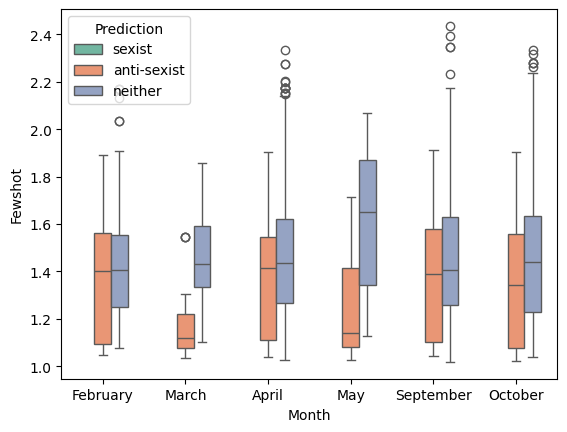

In [285]:
data_values_f = pd.DataFrame({'Prediction': list(more_itertools.flatten(qwen_df['fewshot_results'].to_list())), 
                'Fewshot': list(more_itertools.flatten(qwen_df['fewshot_ppl'].to_list())),
                'Month': newList})

data_values_f['Month'] = data_values_f['Month'].astype("category")
data_values_f['Month'] = data_values_f['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_f['Prediction'] = data_values_f['Prediction'].astype("category")
data_values_f['Prediction'] = data_values_f['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_f = data_values_f.sort_values(["Month", 'Prediction'])

sns.boxplot(data = data_values_f, x='Month', y='Fewshot', hue='Prediction', palette='Set2', width = 0.6)

In [143]:
mistral_df = pd.read_csv('../output_data/mistral.csv').drop(columns={'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'})
mistral_df

,Unnamed: 0.3,uniqueID,text,label,created_at,month,roleplay_results,roleplay_vocab_probs,roleplay_ppl,content_results,content_vocab_probs,content_ppl,fewshot_results,fewshot_vocab_probs,fewshot_ppl,zeroshot_results,zeroshot_vocab_probs,zeroshot_ppl
0,0,antisexm24_uk-0,The rise of Suella Braverman is one of the gen...,sexism,2022-10-25,October,['The text is neither sexist nor anti-sexist.'...,"[array([5.7991676e-12, 1.0391719e-12, 2.822789...","[1.0654199, 1.0654199, 1.0654199]","['Neither', 'neither', 'neither']","[array([9.3241959e-12, 4.0513825e-12, 2.593751...","[1.3491033, 1.3352593, 1.3465228]","['sexist (due to phrasing)', 'sexist (due to p...","[array([8.7924522e-11, 3.7882707e-11, 1.784910...","[1.1660374, 1.1660374, 1.2419661]",['The text is neither sexist nor anti-sexist b...,"[array([1.5387525e-11, 2.7786042e-12, 2.123229...","[1.2852547, 1.378617, 1.378617]"
1,1,antisexm24_uk-1,"General Election please! 81,000 Tory members v...",neither,2022-09-06,September,"['neither', 'neither', 'neither']","[array([1.0528878e-11, 3.2396876e-12, 2.137354...","[1.2782532, 1.3583865, 1.2349942]","['neutral (or neither)', 'neutral/neither', 'n...","[array([6.9932810e-11, 1.7742117e-11, 3.742535...","[1.25503, 1.3815627, 1.25503]",['neutral or anti-sexist (depending on the con...,"[array([4.3781222e-11, 1.2626858e-11, 1.022586...","[1.1219382, 1.1219382, 1.1219382]","['neutral or neither', 'neutral or neither', '...","[array([6.2544340e-12, 2.8243740e-12, 1.313138...","[1.2610977, 1.2610977, 1.2018462]"
2,2,antisexm24_uk-10,If you think you are having a tough day spare ...,neither,2022-09-06,September,"['neither', 'neither', 'neither']","[array([1.6745369e-11, 5.3801659e-12, 5.978780...","[1.1504947, 1.1504947, 1.1504947]","['Neither', 'neither', 'neither']","[array([5.6844807e-12, 2.8831243e-12, 1.123195...","[1.2184042, 1.2073668, 1.2073668]","['neutral or neither', 'neither', 'neutral or ...","[array([1.6704988e-11, 5.3305273e-12, 7.434977...","[1.1644229, 1.3362095, 1.1644229]","['neutral (or neither)', 'Neither', 'neither']","[array([3.4785615e-11, 1.0776302e-11, 2.740077...","[1.1948966, 1.3525013, 1.202189]"
3,3,antisexm24_uk-100,"Already it seems Liz Truss"" ""energy price free...",neither,2022-09-05,September,"['3) neither', 'The text is neither sexist nor...","[array([1.2689286e-10, 1.7640989e-11, 5.640274...","[1.2302978, 1.1841431, 1.2919394]","['neither', 'neither', 'neutral']","[array([8.2330896e-12, 3.3547217e-12, 1.825190...","[1.2466619, 1.2466619, 1.315994]",['The text provided does not contain any sexis...,"[array([3.8061710e-11, 9.6748304e-12, 8.890681...","[1.4382039, 1.3145415, 1.4382039]","['neutral or neither', 'neutral (or neither)',...","[array([6.9668854e-12, 2.1844562e-12, 1.920284...","[1.3226422, 1.2437153, 1.2819488]"
4,4,antisexm24_uk-101,@pritipatel This is not about the location of ...,neither,2022-02-26,February,"['neither', 'neither. The text does not contai...","[array([3.3204092e-11, 9.2376835e-12, 3.073354...","[1.1851187, 1.2696193, 1.1851187]","['neither', 'neither', 'neither']","[array([8.7619079e-12, 3.6569948e-12, 3.022547...","[1.200171, 1.200171, 1.200171]","['neutral or neither', 'neutral or neither', '...","[array([2.0879555e-11, 4.9471850e-12, 2.237590...","[1.1989708, 1.2242113, 1.1989708]","['neutral (or neither)', 'neutral (or neither)...","[array([7.0861553e-11, 1.7935858e-11, 4.759898...","[1.1330466, 1.1330466, 1.1330466]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,1338,antisexm24_uk_pilot-784,Boris Johnson visited Gigg Lane stadium today....,neither,25/04/2022,April,['Neither. The text does not contain any sexis...,"[array([2.8999396e-12, 2.0192381e-12, 5.651138...","[1.2030454, 1.3318732, 1.2266463]","['Neither', 'Neither', 'Neither']","[array([6.0117306e-12, 3.3906894e-12, 1.144127...","[1.2194834, 1.2194834, 1.2194834]","['neutral or neither', 'neutral or neither', '...","[array([1.3579849e-11, 5.1695280e-12, 1.040657...","[1.1989632, 1.1

In [144]:
def maximum(a, b, c): 

    if (a >= b) and (a >= c): 
        largest = a 

    elif (b >= a) and (b >= c): 
        largest = b 
    else: 
        largest = c 
        
    return largest 

In [145]:
def mistral_postprocessing(text):
    #text = re.sub(r"\s+", " ", text)
    #text = text.encode(encoding='ASCII',errors='ignore').decode()
    text = re.sub(r"\s+", " ", text)
    text = text.encode(encoding='ASCII',errors='ignore').decode()

    text = text.replace('2) anti-sexist', 'anti-sexist')
    text = text.replace('3) neither', 'neither')
    text = text.replace('1) sexist', 'sexist')
    text = text.replace('1) anti-sexist', 'anti-sexist')
    text = re.sub(r'[0-9]\)', '', text).strip()

    try:
        if text == 'neither':
            values = ['neither', 'neither', 'neither']

        else:
            '''if text.find('[\'') == -1:
                text = text.replace('[', '[\'')
            elif text.find('\']') == -1:
                text = text.replace(']', '\']')
            else:
                pass'''
            ## first changing the string literals
            text = text.lower().replace('</s>', '')
            #text = text.replace('\\n', '')
            text = text.replace('[', '[')
            text = text.replace('[\\', '[')
            text = text.replace('\\]', ']')
            text = text.replace('\\\'', '\'')
            text = text.replace('\"', '')

            text = text.replace('neutral or neither', 'neither')
            text = text.replace('neutral', 'neither')
            text = ast.literal_eval(text)

            values = []
            for key, val in enumerate(text):
                val = re.sub(r'\n+', '\n', val).split('\n')[0].strip()
                val = val.split('.')[0].strip()
                #val = val.replace('\\n', ';').split(';')[0]
                val = val.split('(')[0].strip()
                if ('cannot provide a label' in val) or ('cannot create' in val):
                    values.append('neither')
                elif (('does not contain' in val) or ('not' in val)) and ('sexist or anti-') in val:
                    values.append('neither')
                elif ('neither' in val) and ('nor' in val):
                    values.append('neither')
                elif (('is' in val) or ('perceived as' in val)) and ('anti-' in val):
                    values.append('anti-sexist')
                elif (('is' in val) or ('perceived as' in val)) and (('sexist' in val) or ('sex' in val)): # 
                    values.append('sexist')
                elif ('the label is: 1' in val) or ('misogyn' in val):
                    values.append('sexist')
                elif val not in ['neither', 'anti-sexist', 'sexist']:
                    a = get_mnli_prediction('anti-sexist', val)
                    b = get_mnli_prediction('sexist', val)
                    c = get_mnli_prediction('neither', val)
                    max = maximum(a, b, c)
                    if max == a:
                        values.append('anti-sexist')
                    elif max == b:
                        values.append('sexist')
                    else:
                        values.append('neither')
                else:
                    values.append(val)
    except Exception as e:
        values = np.nan
    
    return values



In [146]:
mistral_df['roleplay_results'] = mistral_df['roleplay_results'].apply(lambda x: mistral_postprocessing(x))
mistral_df['content_results'] = mistral_df['content_results'].apply(lambda x: mistral_postprocessing(x))
mistral_df['zeroshot_results'] = mistral_df['zeroshot_results'].apply(lambda x: mistral_postprocessing(x))
mistral_df['fewshot_results'] = mistral_df['fewshot_results'].apply(lambda x: mistral_postprocessing(x))

In [147]:
mistral_df['roleplay_ppl'] = mistral_df['roleplay_ppl'].apply(lambda x: handling_error_ppls(x))
mistral_df['content_ppl'] = mistral_df['content_ppl'].apply(lambda x: handling_error_ppls(x))
mistral_df['zeroshot_ppl'] = mistral_df['zeroshot_ppl'].apply(lambda x: handling_error_ppls(x))
mistral_df['fewshot_ppl'] = mistral_df['fewshot_ppl'].apply(lambda x: handling_error_ppls(x))

In [148]:
mistral_df = mistral_df.dropna(subset=['roleplay_results', 'content_results', 'zeroshot_results', 'fewshot_results'])

In [149]:
len(list(more_itertools.flatten(mistral_df['roleplay_ppl'].to_list())))

4005

In [153]:
mistral_df['label'] = mistral_df['label'].apply(lambda x: label_modifiy(x))

/tmp/ipykernel_2900942/3127647276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mistral_df['label'] = mistral_df['label'].apply(lambda x: label_modifiy(x))


In [155]:
cor_labels = mistral_df['label'].to_list()
k = 3
cor_labels = [list(itertools.repeat(element, k)) for element in cor_labels]
cor_labels = list(itertools.chain.from_iterable(cor_labels))
cor_labels

['sexist',
 'sexist',
 'sexist',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'sexist',
 'sexist',
 'sexist',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'anti-sexist',
 'anti-sexist',
 'anti-sexist',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'sexist',
 'sexist',
 'sexist',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 

In [150]:
month_list = mistral_df['month'].to_list()
k = 3
month_list = [list(itertools.repeat(element, k)) for element in month_list]
month_list = list(itertools.chain.from_iterable(month_list))

# Roleplay
data_values_r = pd.DataFrame({'Prediction': list(more_itertools.flatten(mistral_df['roleplay_results'])), 
                'Perplexity': list(more_itertools.flatten(mistral_df['roleplay_ppl'])),
                'Month': month_list})

data_values_r['Month'] = data_values_r['Month'].astype("category")
data_values_r['Month'] = data_values_r['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_r['Prediction'] = data_values_r['Prediction'].astype("category")
data_values_r['Prediction'] = data_values_r['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_r = data_values_r.sort_values(["Month", 'Prediction'])

# Content

data_values_c = pd.DataFrame({'Prediction': list(more_itertools.flatten(mistral_df['content_results'])), 
                'Perplexity': list(more_itertools.flatten(mistral_df['content_ppl'])),
                'Month': month_list})

data_values_c['Month'] = data_values_c['Month'].astype("category")
data_values_c['Month'] = data_values_c['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_c['Prediction'] = data_values_c['Prediction'].astype("category")
data_values_c['Prediction'] = data_values_c['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_c = data_values_c.sort_values(["Month", 'Prediction'])

# Zero-shot
data_values_z = pd.DataFrame({'Prediction': list(more_itertools.flatten(mistral_df['zeroshot_results'])), 
                'Perplexity': list(more_itertools.flatten(mistral_df['zeroshot_ppl'])),
                'Month': month_list})

data_values_z['Month'] = data_values_z['Month'].astype("category")
data_values_z['Month'] = data_values_z['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_z['Prediction'] = data_values_z['Prediction'].astype("category")
data_values_z['Prediction'] = data_values_z['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_z = data_values_z.sort_values(["Month", 'Prediction'])

# Few-shot

data_values_f = pd.DataFrame({'Prediction': list(more_itertools.flatten(mistral_df['fewshot_results'])), 
                'Perplexity': list(more_itertools.flatten(mistral_df['fewshot_ppl'])),
                'Month': month_list})

data_values_f['Month'] = data_values_f['Month'].astype("category")
data_values_f['Month'] = data_values_f['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_f['Prediction'] = data_values_f['Prediction'].astype("category")
data_values_f['Prediction'] = data_values_f['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_f = data_values_f.sort_values(["Month", 'Prediction'])


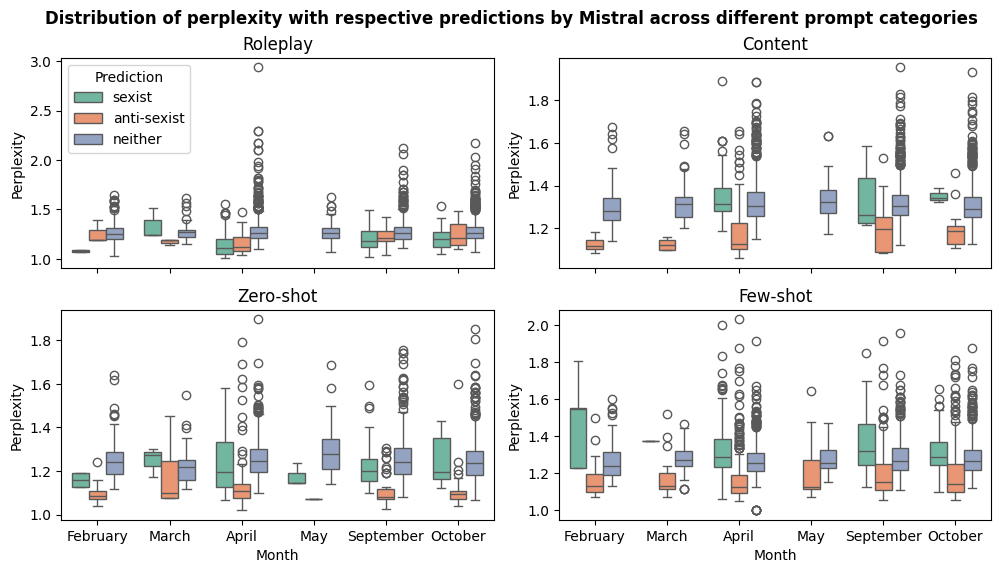

In [152]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.15, hspace=0.2)
fig.suptitle('Distribution of perplexity with respective predictions by Mistral across different prompt categories', x= 0.5, y = 0.96, weight='bold')

# Boxplot for Roleplay
#sns.boxplot(ax=axes[0, 0], data = qwen_df, x='month', y='avg_r_ppl')
sns.boxplot(ax=axs[0, 0], data = data_values_r, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7)#.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#sns.boxplot(ax=axs[0, 0], data = data_values_cor_r, x='Month', y='Roleplay Perplexity'+.10, hue='Prediction', palette='Set2', widths = 0.25, linecolor='red').get_legend().set_visible(False)
axs[0, 0].set_title('Roleplay')
#axes[0].set_title(bulbasaur.name)
#axs[0,0].set_ylim(0.5, 3)

sns.boxplot(ax=axs[0, 1], data = data_values_c, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7).get_legend().set_visible(False)
axs[0, 1].set_title('Content')

sns.boxplot(ax=axs[1, 0], data = data_values_z, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7).get_legend().set_visible(False)
axs[1, 0].set_title('Zero-shot')

sns.boxplot(ax=axs[1, 1], data = data_values_f, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7).get_legend().set_visible(False)
axs[1, 1].set_title('Few-shot')

#fig.savefig("../output_images/perplexity/mistral_perplexity.pdf", bbox_inches='tight')



In [156]:
data_values_cor_r = pd.DataFrame({'Prediction': list(more_itertools.flatten(mistral_df['roleplay_results'])), 
                'Label': cor_labels,
                'Perplexity': list(more_itertools.flatten(mistral_df['roleplay_ppl'])),
                })
data_values_cor_r['Accuracy'] = np.where(data_values_cor_r['Label'] == data_values_cor_r['Prediction'], 'Correct', 'Incorrect')
data_values_cor_r['Prompt type'] = 'Roleplay'


data_values_cor_c = pd.DataFrame({'Prediction': list(more_itertools.flatten(mistral_df['content_results'])), 
                'Label': cor_labels,
                'Perplexity': list(more_itertools.flatten(mistral_df['content_ppl'])),
                })
data_values_cor_c['Accuracy'] = np.where(data_values_cor_c['Label'] == data_values_cor_c['Prediction'], 'Correct', 'Incorrect')
data_values_cor_c['Prompt type'] = 'Content'

data_values_cor_z = pd.DataFrame({'Prediction': list(more_itertools.flatten(mistral_df['zeroshot_results'])), 
                'Label': cor_labels,
                'Perplexity': list(more_itertools.flatten(mistral_df['zeroshot_ppl'])),
                })
data_values_cor_z['Accuracy'] = np.where(data_values_cor_z['Label'] == data_values_cor_z['Prediction'], 'Correct', 'Incorrect')
data_values_cor_z['Prompt type'] = 'Zero-shot'

data_values_cor_f = pd.DataFrame({'Prediction': list(more_itertools.flatten(mistral_df['fewshot_results'])), 
                'Label': cor_labels,
                'Perplexity': list(more_itertools.flatten(mistral_df['fewshot_ppl'])),
                })
data_values_cor_f['Accuracy'] = np.where(data_values_cor_f['Label'] == data_values_cor_f['Prediction'], 'Correct', 'Incorrect')
data_values_cor_f['Prompt type'] = 'Few-shot'

data_values_cor = pd.concat([data_values_cor_r, data_values_cor_c, data_values_cor_z, data_values_cor_f], axis=0)
data_values_cor

,Prediction,Label,Perplexity,Accuracy,Prompt type
0,neither,sexist,1.065420,Incorrect,Roleplay
1,neither,sexist,1.065420,Incorrect,Roleplay
2,neither,sexist,1.065420,Incorrect,Roleplay
3,neither,neither,1.278253,Correct,Roleplay
4,neither,neither,1.358386,Correct,Roleplay
...,...,...,...,...,...
4000,anti-sexist,neither,1.271924,Incorrect,Few-shot
4001,anti-sexist,neither,1.124951,Incorrect,Few-shot
4002,neither,neither,1.204871,Correct,Few-shot
4003,neither,neither,1.167801,Correct,Few-shot


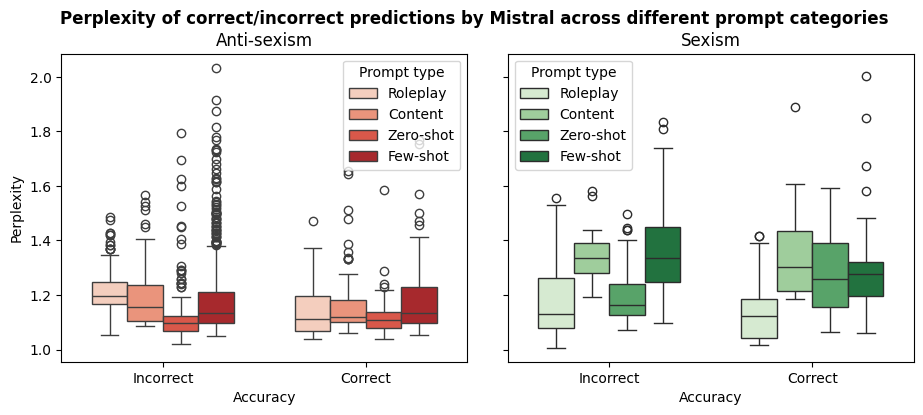

In [159]:
data_values_cor_a = data_values_cor[data_values_cor['Prediction'] == 'anti-sexist']
data_values_cor_s = data_values_cor[data_values_cor['Prediction'] == 'sexist']

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11, 4))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('Perplexity of correct/incorrect predictions by Mistral across different prompt categories', x= 0.5, y = 0.99, weight='bold')

# Boxplot for Roleplay
#sns.boxplot(ax=axes[0, 0], data = qwen_df, x='month', y='avg_r_ppl')
sns.boxplot(ax=axs[0], data = data_values_cor_a, x='Accuracy', y='Perplexity', hue='Prompt type', palette='Reds', width=0.7)#.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#sns.boxplot(ax=axs[0, 0], data = data_values_cor_r, x='Month', y='Roleplay Perplexity'+.10, hue='Prediction', palette='Set2', widths = 0.25, linecolor='red').get_legend().set_visible(False)
axs[0].set_title('Anti-sexism')
#axes[0].set_title(bulbasaur.name)
#axs[0,0].set_ylim(0.5, 3)

sns.boxplot(ax=axs[1], data = data_values_cor_s, x='Accuracy', y='Perplexity', hue='Prompt type', palette='Greens', width=0.7)#.get_legend().set_visible(False)
axs[1].set_title('Sexism')

#fig.savefig("../output_images/perplexity/mistral_perplexity_cor.pdf", bbox_inches='tight')

In [55]:
llama_df = pd.read_csv('../output_data/llama.csv').drop(columns={'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'})
llama_df

,Unnamed: 0.3,uniqueID,text,label,created_at,month,roleplay_results,roleplay_vocab_probs,roleplay_ppl,content_results,content_vocab_probs,content_ppl,zeroshot_results,zeroshot_vocab_probs,zeroshot_ppl,fewshot_results,fewshot_vocab_probs,fewshot_ppl
0,0,antisexm24_uk-0,The rise of Suella Braverman is one of the gen...,sexism,2022-10-25,October,"['sexist', 'sexist', 'sexist']","[array([1.0041786e-08, 5.0319259e-06, 1.066980...","[1.1993037, 1.1993037, 1.1993037]","['sexist', 'sexist', 'sexist']","[array([4.7520405e-09, 9.9058423e-07, 1.282757...","[1.0387933, 1.0387933, 1.0387933]","['sexist', 'sexist', 'sexist']","[array([3.004865e-08, 5.438716e-06, 8.342723e-...","[1.2410558, 1.2410558, 1.2410558]","['sexist', 'sexist', 'sexist']","[array([8.7513330e-09, 7.8379480e-07, 1.335823...","[1.29906, 1.29906, 1.29906]"
1,1,antisexm24_uk-1,"General Election please! 81,000 Tory members v...",neither,2022-09-06,September,"['neither', 'neither', 'neither']","[array([2.0313060e-08, 4.5363977e-06, 7.078448...","[1.3131654, 1.3131654, 1.3131654]","['sexist', 'sexist', 'sexist']","[array([1.6273059e-08, 3.2164694e-06, 3.682028...","[1.3796139, 1.3796139, 1.3796139]","['neither', 'anti-sexist', 'anti-sexist']","[array([3.1707771e-08, 1.8715255e-05, 3.443884...","[1.6786118, 1.3490841, 1.3490841]","['anti-sexist', 'anti-sexist', 'anti-sexist']","[array([8.5732577e-09, 1.2206392e-06, 6.796915...","[1.1587628, 1.1587628, 1.1587628]"
2,2,antisexm24_uk-10,If you think you are having a tough day spare ...,neither,2022-09-06,September,"['neither', 'neither', 'neither']","[array([1.03918545e-08, 2.99953331e-06, 3.5316...","[1.1893731, 1.1893731, 1.1893731]","['sexist', 'sexist', 'sexist']","[array([7.2304474e-09, 1.1982761e-06, 1.493374...","[1.2349303, 1.2349303, 1.2349303]","['neither', 'anti-sexist', 'sexist']","[array([2.1773436e-08, 1.1741449e-05, 2.282787...","[1.4684379, 1.4554889, 1.8288026]","['anti-sexist', 'anti-sexist', 'anti-sexist']","[array([8.0034805e-09, 1.1021899e-06, 4.873364...","[1.2574483, 1.2574483, 1.2574483]"
3,3,antisexm24_uk-100,"Already it seems Liz Truss"" ""energy price free...",neither,2022-09-05,September,"['neither', 'neither', 'neither']","[array([1.4812649e-08, 3.7476702e-06, 6.042896...","[1.3698978, 1.3698978, 1.3698978]","['anti-sexist', 'anti-sexist', 'anti-sexist']","[array([7.8361291e-09, 1.5397956e-06, 1.762476...","[1.0792851, 1.0792851, 1.0792851]","['anti-sexist', 'anti-sexist', 'anti-sexist']","[array([2.0706455e-08, 7.1903373e-06, 1.132513...","[1.1240214, 1.1240214, 1.1240214]","['anti-sexist', 'anti-sexist', 'anti-sexist']","[array([3.3864149e-09, 4.5826084e-07, 1.811738...","[1.0487428, 1.0487428, 1.0487428]"
4,4,antisexm24_uk-101,@pritipatel This is not about the location of ...,neither,2022-02-26,February,"['neither', 'neither', 'neither']","[array([1.2680057e-08, 2.6858334e-06, 6.784444...","[1.2253075, 1.2253075, 1.2253075]","['anti-sexist', 'anti-sexist', 'anti-sexist']","[array([8.4283132e-09, 1.6890847e-06, 2.838195...","[1.1793038, 1.1793038, 1.1793038]","['neither', 'anti-sexist', 'anti-sexist']","[array([2.2614676e-08, 1.4340046e-05, 3.013304...","[1.7013942, 1.2402633, 1.2402633]","['anti-sexist', 'anti-sexist', 'anti-sexist']","[array([7.0725363e-09, 1.0635948e-06, 4.067409...","[1.1142614, 1.1142614, 1.1142614]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,1338,antisexm24_uk_pilot-784,Boris Johnson visited Gigg Lane stadium today....,neither,25/04/2022,April,"['neither', 'neither', 'neither']","[array([2.1387190e-09, 2.5661247e-06, 2.431244...","[1.1021287, 1.1021287, 1.1021287]","['neither', 'neither', 'neither']","[array([3.3098899e-09, 2.7836411e-06, 1.760630...","[1.0051764, 1.0051764, 1.0051764]","['neither', 'neither', 'neither']","[array([6.9272152e-09, 1.2074419e-05, 1.639157...","[1.2035806, 1.2035806, 1.2035806]","['neither', 'neither', 'neither']","[array([3.48125884e-09, 1.15939133e-06, 1.0156...","[1.0171342, 1.0171342, 1.0171342]"
1339,1339

In [56]:
def llama_postprocessing(text):
    text = re.sub(r"\s+", " ", text)
    #text = text.encode(encoding='ASCII',errors='ignore').decode()

    if text == 'neither':
        values = ['neither', 'neither', 'neither']

    else:
        ## first changing the string literals
        text = text.replace('2) anti-sexist', 'anti-sexist')
        text = text.replace('3) neither', 'neither')
        text = text.replace('1) sexist', 'sexist')
        text = text.replace('1) anti-sexist', 'anti-sexist')

        text = ast.literal_eval(text)

        values = []
        for key, val in enumerate(text):
            if ('cannot provide a label' in val) or ('cannot create' in val):
                values.append('neither')
            else:
                val = re.sub(r'\n+', '\n', val).split('\n')[0].strip()
                values.append(val)

    return values

In [57]:
llama_postprocessing("['2) anti-sexist \\n\\nNote: The text is actually', 'sexist', 'cannot create', 'cannot provide a label']")

['anti-sexist', 'sexist', 'neither', 'neither']

In [58]:
llama_postprocessing('neither')

['neither', 'neither', 'neither']

In [59]:
def handling_error_ppls(value):
    
    try:
        if (type(value)==int) or (value == '1'):
            rev_value = [float(1)] * 3
        else:
            rev_value = ast.literal_eval(value)
    except Exception as e:
        print(f'Error type {e}')
        rev_value = [float(1)] * 3
        #value = ast.literal_eval(value)
    
    return rev_value

In [60]:
type(llama_df['zeroshot_ppl'].iloc[60])

str

In [61]:
type(handling_error_ppls(llama_df['zeroshot_ppl'].iloc[0]))

list

In [62]:
type(list(more_itertools.flatten([handling_error_ppls(1), [1.4239227, 1.4239227, 1.4239227]]))[3])

float

In [344]:
llama_df['zeroshot_results'].value_counts().keys().to_list()

In [64]:
list((llama_df['zeroshot_ppl']))

['[1.2410558, 1.2410558, 1.2410558]',
 '[1.6786118, 1.3490841, 1.3490841]',
 '[1.4684379, 1.4554889, 1.8288026]',
 '[1.1240214, 1.1240214, 1.1240214]',
 '[1.7013942, 1.2402633, 1.2402633]',
 '[1.397342, 1.4080423, 1.4080423]',
 '[1.4450191, 1.4450191, 1.5552324]',
 '[1.3805593, 1.3805593, 1.3805593]',
 '[1.2159611, 1.2159611, 1.2159611]',
 '[1.3644521, 1.3644521, 1.3644521]',
 '[1.1202848, 1.1202848, 1.1202848]',
 '[1.3121717, 1.3121717, 1.3121717]',
 '[1.1994205, 1.1994205, 1.1994205]',
 '[1.5143651, 1.4975401, 1.4975401]',
 '[1.2140467, 1.2140467, 1.2140467]',
 '[1.4166046, 1.4166046, 1.4166046]',
 '[1.4704227, 1.4704227, 1.5656455]',
 '[1.2539849, 1.2539849, 1.2539849]',
 '[1.1715034, 1.1715034, 1.1715034]',
 '[1.2768115, 1.2768115, 1.2768115]',
 '[1.4139134, 1.421991, 1.421991]',
 '[1.2601227, 1.2601227, 1.2601227]',
 '[1.3363347, 1.3363347, 1.3363347]',
 '[1.2257409, 1.2257409, 1.2257409]',
 '[1.5339098, 1.5339098, 1.5339098]',
 '[1.1441957, 1.1441957, 1.1441957]',
 '[1.197541, 1.

In [65]:
def label_modifiy(text):
    if text == 'sexism':
        text = 'sexist'
    elif text == 'anti-sexism':
        text = 'anti-sexist'
    else:
        pass
    return text

In [66]:
label_modifiy('anti-sexism')

'anti-sexist'

In [67]:
llama_df['label'] = llama_df['label'].apply(lambda x: label_modifiy(x))

In [68]:
llama_df['roleplay_ppl'] = llama_df['roleplay_ppl'].apply(lambda x: handling_error_ppls(x))
llama_df['content_ppl'] = llama_df['content_ppl'].apply(lambda x: handling_error_ppls(x))
llama_df['zeroshot_ppl'] = llama_df['zeroshot_ppl'].apply(lambda x: handling_error_ppls(x))
llama_df['fewshot_ppl'] = llama_df['fewshot_ppl'].apply(lambda x: handling_error_ppls(x))

In [69]:
llama_df['roleplay_results'] = llama_df['roleplay_results'].apply(lambda x: llama_postprocessing(x))
llama_df['content_results'] = llama_df['content_results'].apply(lambda x: llama_postprocessing(x))
llama_df['zeroshot_results'] = llama_df['zeroshot_results'].apply(lambda x: llama_postprocessing(x))
llama_df['fewshot_results'] = llama_df['fewshot_results'].apply(lambda x: llama_postprocessing(x))

In [70]:
month_list = llama_df['month'].to_list()
k = 3
month_list = [list(itertools.repeat(element, k)) for element in month_list]
month_list = list(itertools.chain.from_iterable(month_list))

In [71]:
# Roleplay
data_values_r = pd.DataFrame({'Prediction': list(more_itertools.flatten(llama_df['roleplay_results'])), 
                'Perplexity': list(more_itertools.flatten(llama_df['roleplay_ppl'])),
                'Month': month_list})

data_values_r['Month'] = data_values_r['Month'].astype("category")
data_values_r['Month'] = data_values_r['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_r['Prediction'] = data_values_r['Prediction'].astype("category")
data_values_r['Prediction'] = data_values_r['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_r = data_values_r.sort_values(["Month", 'Prediction'])

# Content

data_values_c = pd.DataFrame({'Prediction': list(more_itertools.flatten(llama_df['content_results'])), 
                'Perplexity': list(more_itertools.flatten(llama_df['content_ppl'])),
                'Month': month_list})

data_values_c['Month'] = data_values_c['Month'].astype("category")
data_values_c['Month'] = data_values_c['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_c['Prediction'] = data_values_c['Prediction'].astype("category")
data_values_c['Prediction'] = data_values_c['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_c = data_values_c.sort_values(["Month", 'Prediction'])

# Zero-shot
data_values_z = pd.DataFrame({'Prediction': list(more_itertools.flatten(llama_df['zeroshot_results'])), 
                'Perplexity': list(more_itertools.flatten(llama_df['zeroshot_ppl'])),
                'Month': month_list})

data_values_z['Month'] = data_values_z['Month'].astype("category")
data_values_z['Month'] = data_values_z['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_z['Prediction'] = data_values_z['Prediction'].astype("category")
data_values_z['Prediction'] = data_values_z['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_z = data_values_z.sort_values(["Month", 'Prediction'])

# Few-shot

data_values_f = pd.DataFrame({'Prediction': list(more_itertools.flatten(llama_df['fewshot_results'])), 
                'Perplexity': list(more_itertools.flatten(llama_df['fewshot_ppl'])),
                'Month': month_list})

data_values_f['Month'] = data_values_f['Month'].astype("category")
data_values_f['Month'] = data_values_f['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_f['Prediction'] = data_values_f['Prediction'].astype("category")
data_values_f['Prediction'] = data_values_f['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_f = data_values_f.sort_values(["Month", 'Prediction'])

In [72]:
list(more_itertools.flatten(llama_df['content_results']))

['sexist',
 'sexist',
 'sexist',
 'sexist',
 'sexist',
 'sexist',
 'sexist',
 'sexist',
 'sexist',
 'anti-sexist',
 'anti-sexist',
 'anti-sexist',
 'anti-sexist',
 'anti-sexist',
 'anti-sexist',
 'sexist',
 'sexist',
 'sexist',
 'neither',
 'neither',
 'sexist',
 'neither',
 'neither',
 'neither',
 'anti-sexist',
 'sexist',
 'sexist',
 'sexist',
 'neither',
 'neither',
 'anti-sexist',
 'anti-sexist',
 'anti-sexist',
 'sexist',
 'sexist',
 'sexist',
 'anti-sexist',
 'anti-sexist',
 'anti-sexist',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'sexist',
 'sexist',
 'sexist',
 'neither',
 'sexist',
 'anti-sexist',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'sexist',
 'sexist',
 'sexist',
 'anti-sexist',
 'neither',
 'neither',
 'neither',
 'neither',
 'neither',
 'sexist',
 'sexist',
 'sexist',
 'sexist',
 'sexist',
 'sexist',
 'sexist',
 'sexist',
 'sexist',
 'anti-sexist',
 'anti-sexist',
 'anti-sexist',
 'anti-sexist',
 'anti-sexi

In [73]:
llama_df['zeroshot_results'].apply(lambda x: 'yes' if type(x)==list else print(x, type(x))).value_counts()

zeroshot_results
yes    1343
Name: count, dtype: int64

In [74]:
data_values_r['Prediction'].value_counts()

Prediction
neither        2863
sexist          943
anti-sexist     223
Name: count, dtype: int64

Text(0.5, 1.0, 'Few-shot')

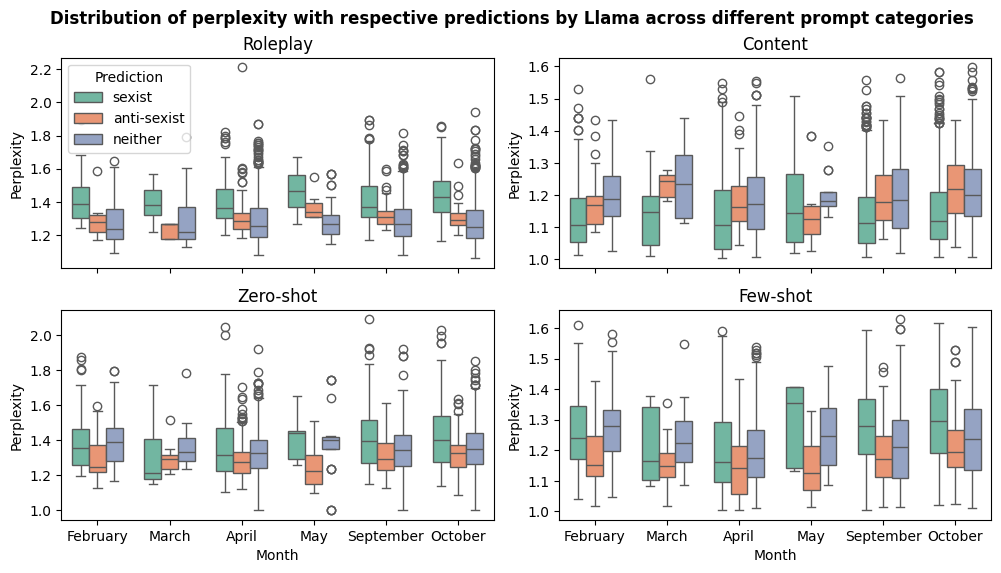

In [75]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.15, hspace=0.2)
fig.suptitle('Distribution of perplexity with respective predictions by Llama across different prompt categories', x= 0.5, y = 0.96, weight='bold')

# Boxplot for Roleplay
#sns.boxplot(ax=axes[0, 0], data = qwen_df, x='month', y='avg_r_ppl')
sns.boxplot(ax=axs[0, 0], data = data_values_r, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7)#.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#sns.boxplot(ax=axs[0, 0], data = data_values_cor_r, x='Month', y='Roleplay Perplexity'+.10, hue='Prediction', palette='Set2', widths = 0.25, linecolor='red').get_legend().set_visible(False)
axs[0, 0].set_title('Roleplay')
#axes[0].set_title(bulbasaur.name)
#axs[0,0].set_ylim(0.5, 3)

sns.boxplot(ax=axs[0, 1], data = data_values_c, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7).get_legend().set_visible(False)
axs[0, 1].set_title('Content')

sns.boxplot(ax=axs[1, 0], data = data_values_z, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7).get_legend().set_visible(False)
axs[1, 0].set_title('Zero-shot')

sns.boxplot(ax=axs[1, 1], data = data_values_f, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7).get_legend().set_visible(False)
axs[1, 1].set_title('Few-shot')

#fig.savefig("../output_images/perplexity/llama_perplexity.pdf", bbox_inches='tight')

In [76]:
cor_labels = llama_df['label'].to_list()
k = 3
cor_labels = [list(itertools.repeat(element, k)) for element in cor_labels]
cor_labels = list(itertools.chain.from_iterable(cor_labels))

In [77]:
data_values_cor_r = pd.DataFrame({'Prediction': list(more_itertools.flatten(llama_df['roleplay_results'])), 
                'Label': cor_labels,
                'Perplexity': list(more_itertools.flatten(llama_df['roleplay_ppl'])),
                })
data_values_cor_r['Accuracy'] = np.where(data_values_cor_r['Label'] == data_values_cor_r['Prediction'], 'Correct', 'Incorrect')
data_values_cor_r['Prompt type'] = 'Roleplay'


data_values_cor_c = pd.DataFrame({'Prediction': list(more_itertools.flatten(llama_df['content_results'])), 
                'Label': cor_labels,
                'Perplexity': list(more_itertools.flatten(llama_df['content_ppl'])),
                })
data_values_cor_c['Accuracy'] = np.where(data_values_cor_c['Label'] == data_values_cor_c['Prediction'], 'Correct', 'Incorrect')
data_values_cor_c['Prompt type'] = 'Content'

data_values_cor_z = pd.DataFrame({'Prediction': list(more_itertools.flatten(llama_df['zeroshot_results'])), 
                'Label': cor_labels,
                'Perplexity': list(more_itertools.flatten(llama_df['zeroshot_ppl'])),
                })
data_values_cor_z['Accuracy'] = np.where(data_values_cor_z['Label'] == data_values_cor_z['Prediction'], 'Correct', 'Incorrect')
data_values_cor_z['Prompt type'] = 'Zero-shot'

data_values_cor_f = pd.DataFrame({'Prediction': list(more_itertools.flatten(llama_df['fewshot_results'])), 
                'Label': cor_labels,
                'Perplexity': list(more_itertools.flatten(llama_df['fewshot_ppl'])),
                })
data_values_cor_f['Accuracy'] = np.where(data_values_cor_f['Label'] == data_values_cor_f['Prediction'], 'Correct', 'Incorrect')
data_values_cor_f['Prompt type'] = 'Few-shot'

data_values_cor = pd.concat([data_values_cor_r, data_values_cor_c, data_values_cor_z, data_values_cor_f], axis=0)
data_values_cor

,Prediction,Label,Perplexity,Accuracy,Prompt type
0,sexist,sexist,1.199304,Correct,Roleplay
1,sexist,sexist,1.199304,Correct,Roleplay
2,sexist,sexist,1.199304,Correct,Roleplay
3,neither,neither,1.313165,Correct,Roleplay
4,neither,neither,1.313165,Correct,Roleplay
...,...,...,...,...,...
4024,anti-sexist,neither,1.014719,Incorrect,Few-shot
4025,anti-sexist,neither,1.014719,Incorrect,Few-shot
4026,anti-sexist,neither,1.343738,Incorrect,Few-shot
4027,neither,neither,1.326324,Correct,Few-shot


In [78]:
data_values_cor_a = data_values_cor[data_values_cor['Prediction'] == 'anti-sexist']
data_values_cor_s = data_values_cor[data_values_cor['Prediction'] == 'sexist']

In [79]:
data_values_cor_s

,Prediction,Label,Perplexity,Accuracy,Prompt type
0,sexist,sexist,1.199304,Correct,Roleplay
1,sexist,sexist,1.199304,Correct,Roleplay
2,sexist,sexist,1.199304,Correct,Roleplay
16,sexist,neither,1.495558,Incorrect,Roleplay
17,sexist,neither,1.495558,Incorrect,Roleplay
...,...,...,...,...,...
3988,sexist,neither,1.083049,Incorrect,Few-shot
3989,sexist,neither,1.083049,Incorrect,Few-shot
3990,sexist,neither,1.121746,Incorrect,Few-shot
3991,sexist,neither,1.121746,Incorrect,Few-shot


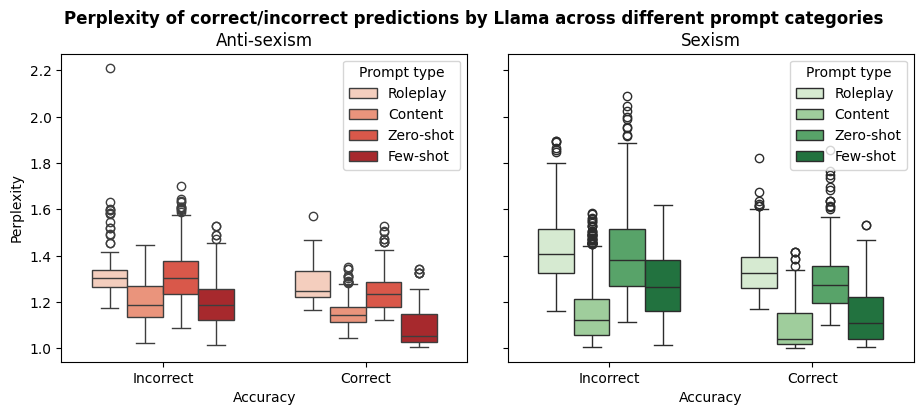

In [80]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11, 4))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('Perplexity of correct/incorrect predictions by Llama across different prompt categories', x= 0.5, y = 0.99, weight='bold')

# Boxplot for Roleplay
#sns.boxplot(ax=axes[0, 0], data = qwen_df, x='month', y='avg_r_ppl')
sns.boxplot(ax=axs[0], data = data_values_cor_a, x='Accuracy', y='Perplexity', hue='Prompt type', palette='Reds', width=0.7)#.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#sns.boxplot(ax=axs[0, 0], data = data_values_cor_r, x='Month', y='Roleplay Perplexity'+.10, hue='Prediction', palette='Set2', widths = 0.25, linecolor='red').get_legend().set_visible(False)
axs[0].set_title('Anti-sexism')
#axes[0].set_title(bulbasaur.name)
#axs[0,0].set_ylim(0.5, 3)

sns.boxplot(ax=axs[1], data = data_values_cor_s, x='Accuracy', y='Perplexity', hue='Prompt type', palette='Greens', width=0.7)#.get_legend().set_visible(False)
axs[1].set_title('Sexism')

#fig.savefig("../output_images/perplexity/llama_perplexity_cor.pdf", bbox_inches='tight')

In [109]:
def creating_avg_probs(list_logits):
    try:
        #formatted_string = re.sub(r'\n+', '\n', list_logits).replace('...,', '')
        formatted_string = list_logits.split(', dtype=float32),') #formatted_string.replace("array", "np.array").replace(", dtype=float32", "")
        #list_logits = ast.literal_eval(formatted_string)

        for key, value in enumerate(formatted_string):
            value = re.sub(r"\s+", " ", value)
            value = value.replace(", ...", "").replace('array([', '').replace(']', '').replace('[', '').strip().replace(', dtype=float32)', '')
            list_logits = [np.array(ast.literal_eval(value))]
            
            # Fix by ensuring all elements are tensors
            list_logits = [torch.tensor(item) if isinstance(item, np.ndarray) else item for item in list_logits]
    
            gen_word_logits = torch.stack([prob.squeeze(0) for prob in list_logits])

            gen_word_probs = torch.nn.functional.softmax(gen_word_logits, dim=1)

            # here we do avg over vocab distributions
            avg_probs = torch.mean(gen_word_probs, dim=0).detach().cpu().numpy()
    except Exception as e:
        avg_probs = np.nan

    return avg_probs

In [282]:
creating_avg_probs(llama_df['roleplay_vocab_probs'].iloc[1000])

array([0.16666489, 0.1666656 , 0.16667485, 0.16666489, 0.16666489,
       0.16666489])

In [285]:
llama_df['roleplay_vocab_probs'] = llama_df['roleplay_vocab_probs'].apply(lambda x: creating_avg_probs(x))
llama_df['content_vocab_probs'] = llama_df['content_vocab_probs'].apply(lambda x: creating_avg_probs(x))
llama_df['zeroshot_vocab_probs'] = llama_df['zeroshot_vocab_probs'].apply(lambda x: creating_avg_probs(x))
llama_df['fewshot_vocab_probs'] = llama_df['fewshot_vocab_probs'].apply(lambda x: creating_avg_probs(x))

In [284]:
llama_df['roleplay_vocab_probs'].apply(lambda x: len(creating_avg_probs(x))).value_counts()

roleplay_vocab_probs
6    1343
Name: count, dtype: int64

In [286]:
llama_df['fewshot_vocab_probs']

0       [0.16666627490291236, 0.16666640407656994, 0.1...
1       [0.16666474580101961, 0.1666649478098042, 0.16...
2       [0.16666528331933825, 0.16666546568232765, 0.1...
3       [0.16666615112574537, 0.1666662269379323, 0.16...
4       [0.16666550822910864, 0.1666656843150217, 0.16...
                              ...                        
1338    [0.16666381349863282, 0.1666640061471247, 0.16...
1339    [0.16666461643806446, 0.16666482800099042, 0.1...
1340    [0.16664602765568648, 0.16664695074100896, 0.1...
1341    [0.16666589996271192, 0.16666599994538625, 0.1...
1342    [0.16666500757168815, 0.1666653762850047, 0.16...
Name: fewshot_vocab_probs, Length: 1343, dtype: object

In [268]:
gemma_df = pd.read_csv('../output_data/gemma.csv').drop(columns={'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'Unnamed: 0.3'})
gemma_df

,uniqueID,text,label,created_at,month,roleplay_results,roleplay_vocab_probs,roleplay_ppl,content_results,content_vocab_probs,content_ppl,zeroshot_results,zeroshot_vocab_probs,zeroshot_ppl
0,antisexm24_uk-0,The rise of Suella Braverman is one of the gen...,sexism,2022-10-25,October,"['sexist', 'sexist', 'sexist']","[array([9.1771637e-20, 5.2951338e-10, 5.375837...","[1.3979071, 1.3979071, 1.4072199]","['sexist', 'sexist', 'sexist']","[array([2.2101005e-19, 4.8892834e-10, 6.653301...","[1.2135657, 1.2135657, 1.2135657]","['sexist', 'sexist', 'sexist']","[array([1.91766509e-20, 5.10989528e-10, 1.2185...","[1.1687512, 1.1687512, 1.228048]"
1,antisexm24_uk-1,"General Election please! 81,000 Tory members v...",neither,2022-09-06,September,"['anti-sexist', 'anti-sexist', 'anti-sexist']","[array([6.3183978e-20, 2.6143185e-10, 2.803947...","[1.1267759, 1.1018207, 1.1267759]","['anti-sexist', 'anti-sexist', 'anti-sexist']","[array([3.7045335e-20, 8.2166531e-09, 3.609904...","[1.1043813, 1.1043813, 1.1043813]","['anti-sexist', 'anti-sexist', 'anti-sexist']","[array([4.0557703e-20, 1.1959628e-09, 4.915121...","[1.0931295, 1.0931295, 1.0931295]"
2,antisexm24_uk-10,If you think you are having a tough day spare ...,neither,2022-09-06,September,"['neither', 'neither', 'neither']","[array([1.5304559e-20, 2.1630549e-10, 3.197721...","[1.251759, 1.1646707, 1.216562]","['neither', 'neither', 'neither']","[array([6.2677653e-20, 3.0412209e-10, 1.218238...","[1.1979177, 1.2213464, 1.2213464]","['neither', 'neither', 'neither']","[array([4.9022313e-20, 1.3693130e-09, 1.218289...","[1.2179235, 1.2179235, 1.2691519]"
3,antisexm24_uk-100,"Already it seems Liz Truss"" ""energy price free...",neither,2022-09-05,September,"['sexist', 'sexist', 'sexist']","[array([6.3907929e-20, 1.4462124e-09, 7.275401...","[1.3460004, 1.4474589, 1.4474589]","['sexist', 'sexist', 'sexist']","[array([1.3895543e-19, 6.2449462e-10, 9.003536...","[1.1401398, 1.1401398, 1.1401398]","['sexist', 'sexist', 'sexist']","[array([1.9649708e-19, 5.1750565e-10, 6.088930...","[1.3104072, 195.43121, 1.3104072]"
4,antisexm24_uk-101,@pritipatel This is not about the location of ...,neither,2022-02-26,February,"['anti-sexist', 'anti-sexist', 'anti-sexist']","[array([1.5397691e-20, 4.4937107e-10, 3.271686...","[1.0369759, 1.0369759, 1.0369759]","['sexist', 'sexist', 'sexist']","[array([1.3480603e-19, 7.0163741e-10, 1.648576...","[1.2628179, 1.3456728, 1.3456728]","['sexist due to ""phrasing""', 'sexist', 'sexist...","[array([1.0638020e-21, 4.1206474e-09, 7.588090...","[1.1639413, 1.2228206, 1.1639413]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,antisexm24_uk_pilot-784,Boris Johnson visited Gigg Lane stadium today....,neither,25/04/2022,April,['<start_of_turn>model\nthe text is neither se...,"[array([3.7039466e-22, 1.7362151e-10, 1.738516...","[1.0276128, 29.15731, 1.0276128]","['neither', 'neither', 'neither']","[array([1.2516799e-21, 3.5626255e-09, 6.636898...","[1.1665401, 1.1903956, 1.1903956]","['neither', 'neither', 'neither']","[array([1.5132923e-21, 1.4320719e-09, 2.447055...","[1.1205978, 1.1339139, 1.1339139]"
1339,antisexm24_uk_pilot-785,@EmilyThornberry @PETAUK This at labour wonâ...,neither,25/04/2022,April,"['sexist', 'sexist', 'sexist']","[array([9.9664323e-20, 2.7717131e-10, 4.902172...","[1.5081049, 24.407467, 28.910616]","['sexist', 'sexist', 'sexist']","[array([4.0886804e-20, 9.8912534e-10, 1.218544...","[1.198757, 1.2874805, 1.2677388]","['sexist', 'sexist', 'sexist']","[array([7.5684336e-21, 6.0994543e-10, 4.482773...","[1.1216705, 21.011652, 1.1216705]"
1340,antisexm24_uk_pilot-786,Queen ð @AngelaRayner https://t.co/7HDiEHy3sJ,neither,25/04/2022,April,"['anti-sexist', 'anti-sexist', 'anti-sexist']","[array([1.9101715e-19, 4.7411047e-10, 9.807352...","[1.2011346, 1.2455192, 1.2455192]","['anti-sexist', 'anti-sexist', 'anti-sexist']","[array([2.3230863e-19, 1.4884852e-09, 2.772771...","[1.2128773, 1.2128773, 1.2128773]","['sexist due to ""context""

In [269]:
def gemma_postprocessing(text):
    text = re.sub(r"\s+", " ", text)
    #text = text.encode(encoding='ASCII',errors='ignore').decode()
    try:
        if text == 'neither':
            values = ['neither', 'neither', 'neither']

        else:
            text = text.replace(r"\\'", "\'")
            text = ast.literal_eval(text)

            values = []
            for key, val in enumerate(text):
                val = re.sub(r'\n+', '\n', val).split('\n')[0].strip()
                if ('cannot provide a label' in val) or ('cannot create' in val) or ('is neither' in val) or ('neither' in val):
                    values.append('neither')
                elif val not in ['neither', 'anti-sexist', 'sexist']:
                        a = get_mnli_prediction('anti-sexist', val)
                        b = get_mnli_prediction('sexist', val)
                        c = get_mnli_prediction('neither', val)
                        max = maximum(a, b, c)
                        if max == a:
                            values.append('anti-sexist')
                        elif max == b:
                            values.append('sexist')
                        else:
                            values.append('neither')
                else:
                    values.append(val)
    except Exception as e:
        values = np.nan

    return values

In [290]:
gemma_df['roleplay_vocab_probs'] = gemma_df['roleplay_vocab_probs'].apply(lambda x: creating_avg_probs(x))
gemma_df['content_vocab_probs'] = gemma_df['content_vocab_probs'].apply(lambda x: creating_avg_probs(x))
gemma_df['zeroshot_vocab_probs'] = gemma_df['zeroshot_vocab_probs'].apply(lambda x: creating_avg_probs(x))

In [281]:
gemma_df['roleplay_ppl'] = gemma_df['roleplay_ppl'].apply(lambda x: handling_error_ppls(x))
gemma_df['content_ppl'] = gemma_df['content_ppl'].apply(lambda x: handling_error_ppls(x))
gemma_df['zeroshot_ppl'] = gemma_df['zeroshot_ppl'].apply(lambda x: handling_error_ppls(x))

In [298]:
gemma_df['roleplay_vocab_probs'].apply(lambda x: len(str(creating_avg_probs(x)))).value_counts()

roleplay_vocab_probs
3    1343
Name: count, dtype: int64

In [299]:
gemma_df['roleplay_results'] = gemma_df['roleplay_results'].apply(lambda x: gemma_postprocessing(x))
gemma_df['content_results'] = gemma_df['content_results'].apply(lambda x: gemma_postprocessing(x))
gemma_df['zeroshot_results'] = gemma_df['zeroshot_results'].apply(lambda x: gemma_postprocessing(x))

In [300]:
month_list = gemma_df['month'].to_list()
k = 3
month_list = [list(itertools.repeat(element, k)) for element in month_list]
month_list = list(itertools.chain.from_iterable(month_list))

In [301]:
# Roleplay
data_values_r = pd.DataFrame({'Prediction': list(more_itertools.flatten(gemma_df['roleplay_results'])), 
                'Perplexity': list(more_itertools.flatten(gemma_df['roleplay_ppl'])),
                'Month': month_list})

data_values_r['Month'] = data_values_r['Month'].astype("category")
data_values_r['Month'] = data_values_r['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_r['Prediction'] = data_values_r['Prediction'].astype("category")
data_values_r['Prediction'] = data_values_r['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_r = data_values_r.sort_values(["Month", 'Prediction'])

# Content

data_values_c = pd.DataFrame({'Prediction': list(more_itertools.flatten(gemma_df['content_results'])), 
                'Perplexity': list(more_itertools.flatten(gemma_df['content_ppl'])),
                'Month': month_list})

data_values_c['Month'] = data_values_c['Month'].astype("category")
data_values_c['Month'] = data_values_c['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_c['Prediction'] = data_values_c['Prediction'].astype("category")
data_values_c['Prediction'] = data_values_c['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_c = data_values_c.sort_values(["Month", 'Prediction'])

# Zero-shot
data_values_z = pd.DataFrame({'Prediction': list(more_itertools.flatten(gemma_df['zeroshot_results'])), 
                'Perplexity': list(more_itertools.flatten(gemma_df['zeroshot_ppl'])),
                'Month': month_list})

data_values_z['Month'] = data_values_z['Month'].astype("category")
data_values_z['Month'] = data_values_z['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_z['Prediction'] = data_values_z['Prediction'].astype("category")
data_values_z['Prediction'] = data_values_z['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_z = data_values_z.sort_values(["Month", 'Prediction'])
'''

# Few-shot

data_values_f = pd.DataFrame({'Prediction': list(more_itertools.flatten(flan_df['fewshot_results'])), 
                'Perplexity': list(more_itertools.flatten(flan_df['fewshot_ppl'])),
                'Month': month_list})

data_values_f['Month'] = data_values_f['Month'].astype("category")
data_values_f['Month'] = data_values_f['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_f['Prediction'] = data_values_f['Prediction'].astype("category")
data_values_f['Prediction'] = data_values_f['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_f = data_values_f.sort_values(["Month", 'Prediction'])'''

'\n\n# Few-shot\n\ndata_values_f = pd.DataFrame({\'Prediction\': list(more_itertools.flatten(flan_df[\'fewshot_results\'])), \n                \'Perplexity\': list(more_itertools.flatten(flan_df[\'fewshot_ppl\'])),\n                \'Month\': month_list})\n\ndata_values_f[\'Month\'] = data_values_f[\'Month\'].astype("category")\ndata_values_f[\'Month\'] = data_values_f[\'Month\'].cat.set_categories([\'February\', \'March\', \'April\', \'May\', \'September\', \'October\'])\n\ndata_values_f[\'Prediction\'] = data_values_f[\'Prediction\'].astype("category")\ndata_values_f[\'Prediction\'] = data_values_f[\'Prediction\'].cat.set_categories([\'sexist\', \'anti-sexist\', \'neither\'])\n\ndata_values_f = data_values_f.sort_values(["Month", \'Prediction\'])'

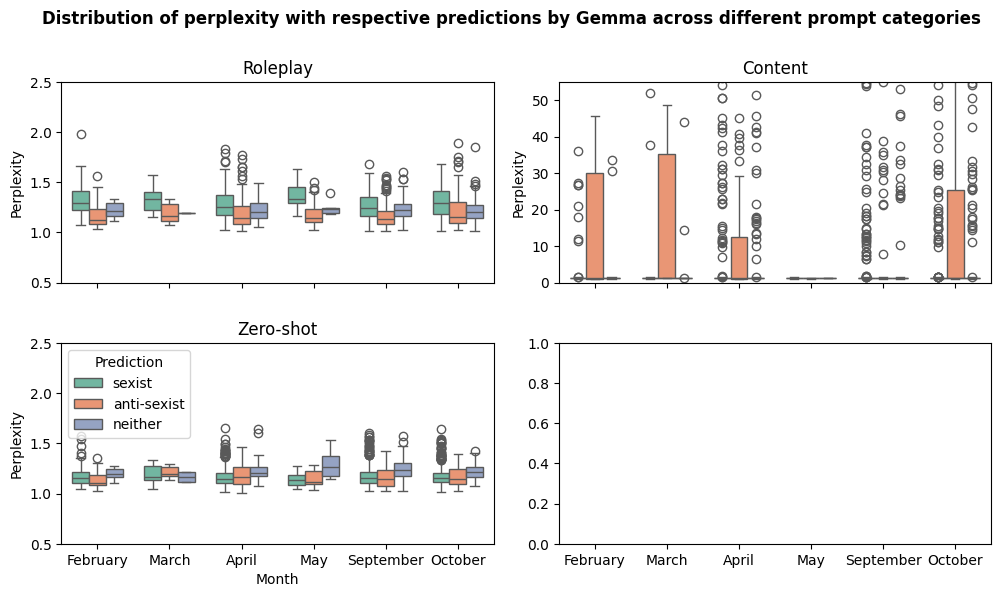

In [315]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.15, hspace=0.3)
fig.suptitle('Distribution of perplexity with respective predictions by Gemma across different prompt categories', x= 0.5, y = 1, weight='bold')

# Boxplot for Roleplay
#sns.boxplot(ax=axes[0, 0], data = qwen_df, x='month', y='avg_r_ppl')
sns.boxplot(ax=axs[0, 0], data = data_values_r, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7).get_legend().set_visible(False)#.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#sns.boxplot(ax=axs[0, 0], data = data_values_cor_r, x='Month', y='Roleplay Perplexity'+.10, hue='Prediction', palette='Set2', widths = 0.25, linecolor='red').get_legend().set_visible(False)
axs[0, 0].set_title('Roleplay')
#axs[0, 0].set_ylim(0.7, 3)
#axes[0].set_title(bulbasaur.name)
axs[0,0].set_ylim(0.5, 2.5)

sns.boxplot(ax=axs[0, 1], data = data_values_c, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7).get_legend().set_visible(False)
axs[0, 1].set_title('Content')
axs[0, 1].set_ylim(0, 55)

sns.boxplot(ax=axs[1, 0], data = data_values_z, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7)
axs[1, 0].set_title('Zero-shot')
axs[1, 0].set_ylim(0.5, 2.5)

'''sns.boxplot(ax=axs[1, 1], data = data_values_f, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7).get_legend().set_visible(False)
axs[1, 1].set_title('Few-shot')
axs[1, 1].set_ylim(0.7, 3)'''

#fig.savefig("../output_images/perplexity/gemma_perplexity.pdf", bbox_inches='tight')

In [316]:
gemma_df['label'] = gemma_df['label'].apply(lambda x: label_modifiy(x))

In [317]:
cor_labels_r = gemma_df['label'].to_list()
k = 3
cor_labels_r = [list(itertools.repeat(element, k)) for element in cor_labels_r]
cor_labels_r = list(itertools.chain.from_iterable(cor_labels_r))
len(cor_labels_r)

4029

In [319]:
data_values_cor_r = pd.DataFrame({'Prediction': list(more_itertools.flatten(gemma_df['roleplay_results'])), 
                'Label': cor_labels_r,
                'Perplexity': list(more_itertools.flatten(gemma_df['roleplay_ppl'])),
                })
data_values_cor_r['Accuracy'] = np.where(data_values_cor_r['Label'] == data_values_cor_r['Prediction'], 'Correct', 'Incorrect')
data_values_cor_r['Prompt type'] = 'Roleplay'


data_values_cor_c = pd.DataFrame({'Prediction': list(more_itertools.flatten(gemma_df['content_results'])), 
                'Label': cor_labels_r,
                'Perplexity': list(more_itertools.flatten(gemma_df['content_ppl'])),
                })
data_values_cor_c['Accuracy'] = np.where(data_values_cor_c['Label'] == data_values_cor_c['Prediction'], 'Correct', 'Incorrect')
data_values_cor_c['Prompt type'] = 'Content'

data_values_cor_z = pd.DataFrame({'Prediction': list(more_itertools.flatten(gemma_df['zeroshot_results'])), 
                'Label': cor_labels_r,
                'Perplexity': list(more_itertools.flatten(gemma_df['zeroshot_ppl'])),
                })
data_values_cor_z['Accuracy'] = np.where(data_values_cor_z['Label'] == data_values_cor_z['Prediction'], 'Correct', 'Incorrect')
data_values_cor_z['Prompt type'] = 'Zero-shot'

'''data_values_cor_f = pd.DataFrame({'Prediction': list(more_itertools.flatten(flan_df['fewshot_results'])), 
                'Label': cor_labels_r,
                'Perplexity': list(more_itertools.flatten(flan_df['fewshot_ppl'])),
                })
data_values_cor_f['Accuracy'] = np.where(data_values_cor_f['Label'] == data_values_cor_f['Prediction'], 'Correct', 'Incorrect')
data_values_cor_f['Prompt type'] = 'Few-shot'
'''

data_values_cor = pd.concat([data_values_cor_r, data_values_cor_c, data_values_cor_z], axis=0) #, data_values_cor_f
data_values_cor

,Prediction,Label,Perplexity,Accuracy,Prompt type
0,sexist,sexist,1.397907,Correct,Roleplay
1,sexist,sexist,1.397907,Correct,Roleplay
2,sexist,sexist,1.407220,Correct,Roleplay
3,anti-sexist,neither,1.126776,Incorrect,Roleplay
4,anti-sexist,neither,1.101821,Incorrect,Roleplay
...,...,...,...,...,...
4024,sexist,neither,1.147337,Incorrect,Zero-shot
4025,sexist,neither,1.147337,Incorrect,Zero-shot
4026,sexist,neither,1.138698,Incorrect,Zero-shot
4027,sexist,neither,316.523860,Incorrect,Zero-shot


In [320]:
data_values_cor_a = data_values_cor[data_values_cor['Prediction'] == 'anti-sexist']
data_values_cor_s = data_values_cor[data_values_cor['Prediction'] == 'sexist']

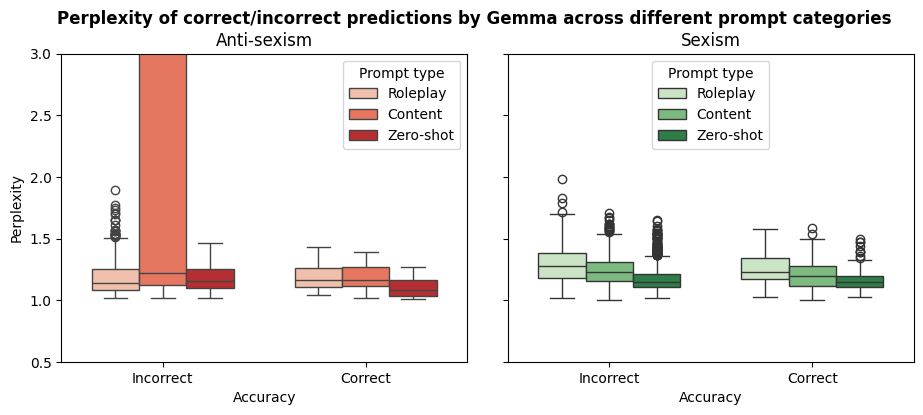

In [322]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11, 4))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('Perplexity of correct/incorrect predictions by Gemma across different prompt categories', x= 0.5, y = 0.99, weight='bold')

# Boxplot for Roleplay
#sns.boxplot(ax=axes[0, 0], data = qwen_df, x='month', y='avg_r_ppl')
sns.boxplot(ax=axs[0], data = data_values_cor_a, x='Accuracy', y='Perplexity', hue='Prompt type', palette='Reds', width=0.7)#.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#sns.boxplot(ax=axs[0, 0], data = data_values_cor_r, x='Month', y='Roleplay Perplexity'+.10, hue='Prediction', palette='Set2', widths = 0.25, linecolor='red').get_legend().set_visible(False)
axs[0].set_title('Anti-sexism')
#axes[0].set_title(bulbasaur.name)
axs[0].set_ylim(0.5, 3)

sns.boxplot(ax=axs[1], data = data_values_cor_s, x='Accuracy', y='Perplexity', hue='Prompt type', palette='Greens', width=0.7)#.get_legend().set_visible(False)
axs[1].set_title('Sexism')
axs[1].set_ylim(0.5, 3)

#fig.savefig("../output_images/perplexity/gemma_perplexity_cor.pdf", bbox_inches='tight')

In [234]:
flan_df = pd.read_csv('../output_data/flan.csv').drop(columns={'Unnamed: 0.1', 'Unnamed: 0'})
flan_df

,Unnamed: 0.2,uniqueID,text,label,created_at,month,roleplay_results,roleplay_vocab_probs,roleplay_ppl,content_results,content_vocab_probs,content_ppl,zeroshot_results,zeroshot_vocab_probs,zeroshot_ppl,fewshot_results,fewshot_vocab_probs,fewshot_ppl
0,0,antisexm24_uk-0,The rise of Suella Braverman is one of the gen...,sexism,2022-10-25,October,"['anti-sexist', 'anti-sexist', 'anti-sexist']","[array([-0.08265321, 0. , 0. ,...","[1.016668, 1.016668, 1.016668]","['sexist', 'neither', 'sexist']","[array([-0.21623431, 0. , 0. ,...","[1.0555464, 1.0555464, 1.0555464]","['sexist', 'sexist', 'sexist']","[array([-0.00033945, 0. , 0. ,...","[1.0000849, 1.0000849, 1.0000849]","['sexist', 'sexist', 'sexist']","[array([-0.00408232, 0. , 0. ,...","[1.0010211, 1.0010211, 1.0010211]"
1,1,antisexm24_uk-1,"General Election please! 81,000 Tory members v...",neither,2022-09-06,September,"['neither', 'neither', 'neither']","[array([-0.00042441, 0. ], dtype=float...","[1.0002122, 1.0002122, 1.0002122]","['neither', 'neither', 'neither']","[array([-9.298281e-06, 0.000000e+00], dtype=f...","[1.0000046, 1.0000046, 1.0000046]","['neither', 'neither', 'neither']","[array([-2.622601e-06, 0.000000e+00], dtype=f...","[1.0000013, 1.0000013, 1.0000013]","['neither', 'neither', 'neither']","[array([-5.0067774e-06, 0.0000000e+00], dtype...","[1.0000025, 1.0000025, 1.0000025]"
2,2,antisexm24_uk-10,If you think you are having a tough day spare ...,neither,2022-09-06,September,"['neither', 'neither', 'neither']","[array([-0.00011575, 0. ], dtype=float...","[1.0000578, 1.0000578, 1.0000578]","['neither', 'neither', 'neither']","[array([-1.9073468e-06, 0.0000000e+00], dtype...","[1.000001, 1.000001, 1.000001]","['neither', 'neither', 'neither']","[array([-5.960463e-07, 0.000000e+00], dtype=f...","[1.0000004, 1.0000004, 1.0000004]","['neither', 'neither', 'neither']","[array([-2.384183e-06, 0.000000e+00], dtype=f...","[1.0000012, 1.0000012, 1.0000012]"
3,3,antisexm24_uk-100,"Already it seems Liz Truss"" ""energy price free...",neither,2022-09-05,September,"['neither', 'neither', 'neither']","[array([-1.6689287e-06, 0.0000000e+00], dtype...","[1.0000008, 1.0000008, 1.0000008]","['neither', 'neither', 'neither']","[array([-2.3841855e-07, 0.0000000e+00], dtype...","[1.0000002, 1.0000002, 1.0000002]","['neither', 'neither', 'neither']","[array([-2.3841855e-07, 0.0000000e+00], dtype...","[1.0000002, 1.0000002, 1.0000002]","['neither', 'neither', 'neither']","[array([-1.5497195e-06, 0.0000000e+00], dtype...","[1.0000008, 1.0000008, 1.0000008]"
4,4,antisexm24_uk-101,@pritipatel This is not about the location of ...,neither,2022-02-26,February,"['neither', 'neither', 'neither']","[array([-1.3113013e-06, 0.0000000e+00], dtype...","[1.0000007, 1.0000007, 1.0000007]","['neither', 'neither', 'neither']","[array([-9.5367386e-07, 0.0000000e+00], dtype...","[1.0000005, 1.0000005, 1.0000005]","['neither', 'neither', 'neither']","[array([-5.960463e-07, 0.000000e+00], dtype=f...","[1.0000004, 1.0000004, 1.0000004]","['neither', 'neither', 'neither']","[array([-2.9802277e-06, 0.0000000e+00], dtype...","[1.0000015, 1.0000015, 1.0000015]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,1338,antisexm24_uk_pilot-784,Boris Johnson visited Gigg Lane stadium today....,neither,25/04/2022,April,"['neither', 'neither', 'neither']","[array([0., 0.], dtype=float32), array([0., 0....","[1.0, 1.0, 1.0]","['neither', 'neither', 'neither']","[array([0., 0.], dtype=float32), array([0., 0....","[1.0, 1.0, 1.0]","['neither', 'neither', 'neither']","[array([0., 0.], dtype=float32), array([0., 0....","[1.0, 1.0, 1.0]","['neither', 'neither', 'neither']","[array([0., 0.], dtype=float32), array([0., 0....","[1.0, 1.0, 1.0]"
1339,1339,antisexm24_uk_pilot-785,@EmilyThornberry @PETAUK This at labour wonâ...,neither,25/04/2022,April,"['sexist', 'sexist', 'sexist']","[array([-0.076753, 0. , 0. , 0. ...","[1.0193734, 1.0193734, 1.0193734]","['sexist', 'sexist', 'sexist']","[array

In [235]:
def flan_postprocessing(text):
    text = re.sub(r"\s+", " ", text)
    #text = text.encode(encoding='ASCII',errors='ignore').decode()
    try:
        if text == 'neither':
            values = ['neither', 'neither', 'neither']

        else:

            text = ast.literal_eval(text)

            values = []
            for key, val in enumerate(text):
                val = re.sub(r'\n+', '\n', val).split('\n')[0].strip()
                if ('cannot provide a label' in val) or ('cannot create' in val) or ('is neither' in val) or ('neither' in val):
                    values.append('neither')
                elif val not in ['neither', 'anti-sexist', 'sexist']:
                        a = get_mnli_prediction('anti-sexist', val)
                        b = get_mnli_prediction('sexist', val)
                        c = get_mnli_prediction('neither', val)
                        max = maximum(a, b, c)
                        if max == a:
                            values.append('anti-sexist')
                        elif max == b:
                            values.append('sexist')
                        else:
                            values.append('neither')
                else:
                    values.append(val)
    except Exception as e:
        values = np.nan

    return values

In [236]:
flan_df['roleplay_ppl'] = flan_df['roleplay_ppl'].apply(lambda x: handling_error_ppls(x))
flan_df['content_ppl'] = flan_df['content_ppl'].apply(lambda x: handling_error_ppls(x))
flan_df['zeroshot_ppl'] = flan_df['zeroshot_ppl'].apply(lambda x: handling_error_ppls(x))
flan_df['fewshot_ppl'] = flan_df['fewshot_ppl'].apply(lambda x: handling_error_ppls(x))

Error type malformed node or string on line 1: <ast.Name object at 0x7fc7a2386860>
Error type malformed node or string on line 1: <ast.Name object at 0x7fc7a2220760>
Error type malformed node or string on line 1: <ast.Name object at 0x7fc7a2221f90>
Error type malformed node or string on line 1: <ast.Name object at 0x7fc7a2220e80>
Error type malformed node or string on line 1: <ast.Name object at 0x7fc7a2277a90>
Error type malformed node or string on line 1: <ast.Name object at 0x7fc7a23863e0>
Error type malformed node or string on line 1: <ast.Name object at 0x7fc7a2387970>
Error type malformed node or string on line 1: <ast.Name object at 0x7fc7a2222bf0>
Error type malformed node or string on line 1: <ast.Name object at 0x7fc7a22218d0>
Error type malformed node or string on line 1: <ast.Name object at 0x7fc7a2387850>
Error type malformed node or string on line 1: <ast.Name object at 0x7fc7a2222890>
Error type malformed node or string on line 1: <ast.Name object at 0x7fc7a22221d0>
Erro

In [237]:
flan_df['fewshot_ppl'].apply(lambda x: 'no' if type(x)==list else 'yes').value_counts()

fewshot_ppl
no    1343
Name: count, dtype: int64

In [238]:
flan_df['roleplay_results'] = flan_df['roleplay_results'].apply(lambda x: flan_postprocessing(x))
flan_df['content_results'] = flan_df['content_results'].apply(lambda x: flan_postprocessing(x))
flan_df['zeroshot_results'] = flan_df['zeroshot_results'].apply(lambda x: flan_postprocessing(x))
flan_df['fewshot_results'] = flan_df['fewshot_results'].apply(lambda x: flan_postprocessing(x))

In [239]:
month_list = flan_df['month'].to_list()
k = 3
month_list = [list(itertools.repeat(element, k)) for element in month_list]
month_list = list(itertools.chain.from_iterable(month_list))

In [240]:
# Roleplay
data_values_r = pd.DataFrame({'Prediction': list(more_itertools.flatten(flan_df['roleplay_results'])), 
                'Perplexity': list(more_itertools.flatten(flan_df['roleplay_ppl'])),
                'Month': month_list})

data_values_r['Month'] = data_values_r['Month'].astype("category")
data_values_r['Month'] = data_values_r['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_r['Prediction'] = data_values_r['Prediction'].astype("category")
data_values_r['Prediction'] = data_values_r['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_r = data_values_r.sort_values(["Month", 'Prediction'])

# Content

data_values_c = pd.DataFrame({'Prediction': list(more_itertools.flatten(flan_df['content_results'])), 
                'Perplexity': list(more_itertools.flatten(flan_df['content_ppl'])),
                'Month': month_list})

data_values_c['Month'] = data_values_c['Month'].astype("category")
data_values_c['Month'] = data_values_c['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_c['Prediction'] = data_values_c['Prediction'].astype("category")
data_values_c['Prediction'] = data_values_c['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_c = data_values_c.sort_values(["Month", 'Prediction'])

# Zero-shot
data_values_z = pd.DataFrame({'Prediction': list(more_itertools.flatten(flan_df['zeroshot_results'])), 
                'Perplexity': list(more_itertools.flatten(flan_df['zeroshot_ppl'])),
                'Month': month_list})

data_values_z['Month'] = data_values_z['Month'].astype("category")
data_values_z['Month'] = data_values_z['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_z['Prediction'] = data_values_z['Prediction'].astype("category")
data_values_z['Prediction'] = data_values_z['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_z = data_values_z.sort_values(["Month", 'Prediction'])

# Few-shot

data_values_f = pd.DataFrame({'Prediction': list(more_itertools.flatten(flan_df['fewshot_results'])), 
                'Perplexity': list(more_itertools.flatten(flan_df['fewshot_ppl'])),
                'Month': month_list})

data_values_f['Month'] = data_values_f['Month'].astype("category")
data_values_f['Month'] = data_values_f['Month'].cat.set_categories(['February', 'March', 'April', 'May', 'September', 'October'])

data_values_f['Prediction'] = data_values_f['Prediction'].astype("category")
data_values_f['Prediction'] = data_values_f['Prediction'].cat.set_categories(['sexist', 'anti-sexist', 'neither'])

data_values_f = data_values_f.sort_values(["Month", 'Prediction'])

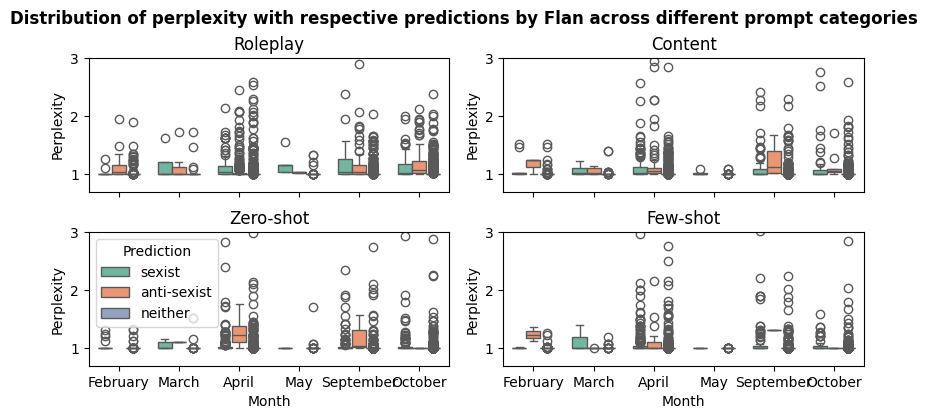

In [262]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10, 4))
fig.subplots_adjust(wspace=0.15, hspace=0.3)
fig.suptitle('Distribution of perplexity with respective predictions by Flan across different prompt categories', x= 0.5, y = 1, weight='bold')

# Boxplot for Roleplay
#sns.boxplot(ax=axes[0, 0], data = qwen_df, x='month', y='avg_r_ppl')
sns.boxplot(ax=axs[0, 0], data = data_values_r, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7).get_legend().set_visible(False)#.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#sns.boxplot(ax=axs[0, 0], data = data_values_cor_r, x='Month', y='Roleplay Perplexity'+.10, hue='Prediction', palette='Set2', widths = 0.25, linecolor='red').get_legend().set_visible(False)
axs[0, 0].set_title('Roleplay')
axs[0, 0].set_ylim(0.7, 3)
#axes[0].set_title(bulbasaur.name)
#axs[0,0].set_ylim(0.5, 3)

sns.boxplot(ax=axs[0, 1], data = data_values_c, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7).get_legend().set_visible(False)
axs[0, 1].set_title('Content')
axs[0, 1].set_ylim(0.7, 3)

sns.boxplot(ax=axs[1, 0], data = data_values_z, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7)
axs[1, 0].set_title('Zero-shot')
axs[1, 0].set_ylim(0.7, 3)

sns.boxplot(ax=axs[1, 1], data = data_values_f, x='Month', y='Perplexity', hue='Prediction', palette='Set2', width=0.7).get_legend().set_visible(False)
axs[1, 1].set_title('Few-shot')
axs[1, 1].set_ylim(0.7, 3)

fig.savefig("../output_images/perplexity/flan_perplexity.pdf", bbox_inches='tight')

In [261]:
flan_df['label'] = flan_df['label'].apply(lambda x: label_modifiy(x))

In [247]:
len(flan_df['label'].to_list())

1343

In [248]:
cor_labels_r = flan_df['label'].to_list()
k = 3
cor_labels_r = [list(itertools.repeat(element, k)) for element in cor_labels_r]
cor_labels_r = list(itertools.chain.from_iterable(cor_labels_r))
len(cor_labels_r)

4029

In [249]:
len(list(more_itertools.flatten(flan_df['roleplay_ppl']))), len(list(more_itertools.flatten(flan_df['roleplay_results']))), len(cor_labels_r)

(4029, 4029, 4029)

In [250]:
data_values_cor_r = pd.DataFrame({'Prediction': list(more_itertools.flatten(flan_df['roleplay_results'])), 
                'Label': cor_labels_r,
                'Perplexity': list(more_itertools.flatten(flan_df['roleplay_ppl'])),
                })
data_values_cor_r['Accuracy'] = np.where(data_values_cor_r['Label'] == data_values_cor_r['Prediction'], 'Correct', 'Incorrect')
data_values_cor_r['Prompt type'] = 'Roleplay'


data_values_cor_c = pd.DataFrame({'Prediction': list(more_itertools.flatten(flan_df['content_results'])), 
                'Label': cor_labels_r,
                'Perplexity': list(more_itertools.flatten(flan_df['content_ppl'])),
                })
data_values_cor_c['Accuracy'] = np.where(data_values_cor_c['Label'] == data_values_cor_c['Prediction'], 'Correct', 'Incorrect')
data_values_cor_c['Prompt type'] = 'Content'

data_values_cor_z = pd.DataFrame({'Prediction': list(more_itertools.flatten(flan_df['zeroshot_results'])), 
                'Label': cor_labels_r,
                'Perplexity': list(more_itertools.flatten(flan_df['zeroshot_ppl'])),
                })
data_values_cor_z['Accuracy'] = np.where(data_values_cor_z['Label'] == data_values_cor_z['Prediction'], 'Correct', 'Incorrect')
data_values_cor_z['Prompt type'] = 'Zero-shot'

data_values_cor_f = pd.DataFrame({'Prediction': list(more_itertools.flatten(flan_df['fewshot_results'])), 
                'Label': cor_labels_r,
                'Perplexity': list(more_itertools.flatten(flan_df['fewshot_ppl'])),
                })
data_values_cor_f['Accuracy'] = np.where(data_values_cor_f['Label'] == data_values_cor_f['Prediction'], 'Correct', 'Incorrect')
data_values_cor_f['Prompt type'] = 'Few-shot'

data_values_cor = pd.concat([data_values_cor_r, data_values_cor_c, data_values_cor_z, data_values_cor_f], axis=0)
data_values_cor

,Prediction,Label,Perplexity,Accuracy,Prompt type
0,anti-sexist,sexist,1.016668,Incorrect,Roleplay
1,anti-sexist,sexist,1.016668,Incorrect,Roleplay
2,anti-sexist,sexist,1.016668,Incorrect,Roleplay
3,neither,neither,1.000212,Correct,Roleplay
4,neither,neither,1.000212,Correct,Roleplay
...,...,...,...,...,...
4024,anti-sexist,neither,1.005220,Incorrect,Few-shot
4025,sexist,neither,1.005220,Incorrect,Few-shot
4026,neither,neither,1.000007,Correct,Few-shot
4027,neither,neither,1.000007,Correct,Few-shot


In [264]:
data_values_cor_a = data_values_cor[data_values_cor['Prediction'] == 'anti-sexist']
data_values_cor_s = data_values_cor[data_values_cor['Prediction'] == 'sexist']

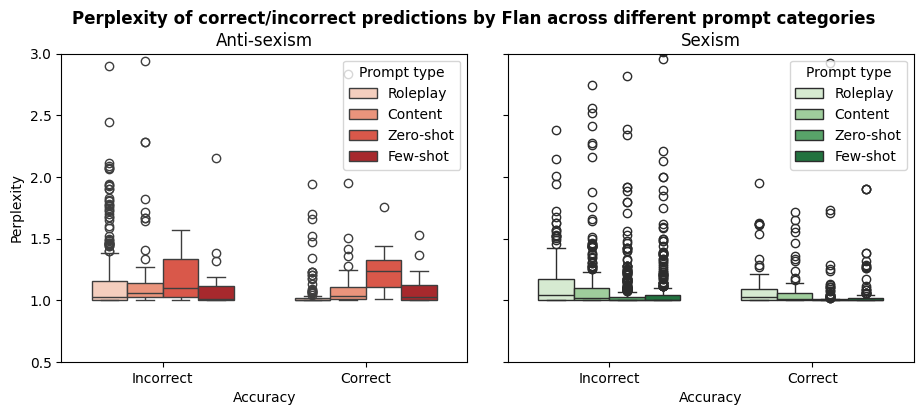

In [267]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11, 4))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('Perplexity of correct/incorrect predictions by Flan across different prompt categories', x= 0.5, y = 0.99, weight='bold')

# Boxplot for Roleplay
#sns.boxplot(ax=axes[0, 0], data = qwen_df, x='month', y='avg_r_ppl')
sns.boxplot(ax=axs[0], data = data_values_cor_a, x='Accuracy', y='Perplexity', hue='Prompt type', palette='Reds', width=0.7)#.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#sns.boxplot(ax=axs[0, 0], data = data_values_cor_r, x='Month', y='Roleplay Perplexity'+.10, hue='Prediction', palette='Set2', widths = 0.25, linecolor='red').get_legend().set_visible(False)
axs[0].set_title('Anti-sexism')
#axes[0].set_title(bulbasaur.name)
axs[0].set_ylim(0.5, 3)

sns.boxplot(ax=axs[1], data = data_values_cor_s, x='Accuracy', y='Perplexity', hue='Prompt type', palette='Greens', width=0.7)#.get_legend().set_visible(False)
axs[1].set_title('Sexism')
axs[1].set_ylim(0.5, 3)

fig.savefig("../output_images/perplexity/flan_perplexity_cor.pdf", bbox_inches='tight')

In [287]:
flan_df['roleplay_vocab_probs'] = flan_df['roleplay_vocab_probs'].apply(lambda x: creating_avg_probs(x))
flan_df['content_vocab_probs'] = flan_df['content_vocab_probs'].apply(lambda x: creating_avg_probs(x))
flan_df['zeroshot_vocab_probs'] = flan_df['zeroshot_vocab_probs'].apply(lambda x: creating_avg_probs(x))
flan_df['fewshot_vocab_probs'] = flan_df['fewshot_vocab_probs'].apply(lambda x: creating_avg_probs(x))

In [289]:
#flan_df['roleplay_vocab_probs'].apply(lambda x: len(creating_avg_probs(x))).value_counts()
flan_df['roleplay_vocab_probs']

0       [0.062367543559532286, 0.06774144744345026, 0....
1               [0.49989389750159263, 0.5001061024984074]
2                [0.4999710625000323, 0.5000289374999677]
3                  [0.499999582767825, 0.500000417232175]
4                  [0.499999672174675, 0.500000327825325]
                              ...                        
1338                                           [0.5, 0.5]
1339    [0.2358865527279927, 0.25470448242400245, 0.25...
1340                   [0.4999983608776, 0.5000016391224]
1341    [0.06650964931757877, 0.06670592100393864, 0.0...
1342            [0.49997127250003165, 0.5000287274999684]
Name: roleplay_vocab_probs, Length: 1343, dtype: object

In [168]:
values1 = np.asarray([1.346112,1.337432,1.246655])
values2 = np.asarray([1.033836,1.082015,1.117323])


In [ ]:
def get_persuasion_score(self, clus_a, clus_b, probs_a, probs_b):
        probs_a_list = []
        for clus in clusters_a:
            probs_a = obtain_rep_probs(clus_a, probs_a)
            probs_a_list.append(probs_a)

        probs_b_list = []
        for clus in clusters_b:
            probs_b = obtain_rep_probs(clus_b, probs_b)
            probs_b_list.append(probs_b)

        persuasion_score = []
        for pa in probs_a_list:
            for pb in probs_b_list:
                persuasion_per = self.calculate_kl_div(pa, pb)
                persuasion_score.append(persuasion_per)

        return persuasion_score

In [275]:
distance.jensenshannon(values1, values2)

0.022606398886558975